In [1]:
import cv2
import toml
import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toolz import concatv
from pathlib import Path
from tqdm.auto import tqdm
from aging.size_norm.data import clean
from aging.plotting import format_plots, PlotConfig, save_factory

In [2]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / "network-optim", tight_layout=False)

In [3]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/param_scan_06/stage_01')

In [24]:
subfolders = [f for f in concatv(folder.glob('*/'), folder.with_name("stage_02").glob('*/'))  if f.is_dir()]

In [5]:
def get_mag(s):
    if s == 'K':
        return 1e3
    elif s == 'M':
        return 1e6
    else:
        raise NotImplemented()

In [192]:
# relevant parameters are: lightning/arch, model/init_channel, model/init_depth, model/channel_scaling, model/depth_scaling
results = []
for f in tqdm(subfolders):
    try:
        config = toml.load(f / "config.toml")
        mse_df_files = sorted((f / "size_norm_scan").glob("**/metrics.csv"))
        mse_df = []
        for _file in mse_df_files:
            mse_df.append(pd.read_csv(_file))
        mse_df = pd.concat(mse_df, ignore_index=True)
        max_epoch = mse_df['epoch'].max()
        train_mse = mse_df['train_loss'].quantile(0.05)
        mse = mse_df['val_loss'].quantile(0.05)
        stopped = ((f / "model.pt").exists() or (max_epoch >= 199)) and (max_epoch > 20)
        # beh_mse = mse_df['val_mse'].dropna().iloc[-1]
        # validation = mse_df[['val_r2', 'heldout_r2']].dropna().iloc[-1]
        with open(list(f.glob('model*.out'))[0], 'r') as out_f:
            for line in out_f.readlines():
                if "Total params" in line:
                    params = line.split(' ')[:2]
                    params = float(params[0]) * get_mag(params[1])
        results.append(dict(
            depth=config['model']['depth'],
            arch=config['model']['lightning']['arch'],
            channel_scaling=config['model']['channel_scaling'],
            depth_scaling=config['model']['depth_scaling'],
            init_depth=config['model']['init_depth'],
            init_channel=config['model']['init_channel'],
            mse=mse,
            uuid=f.name,
            stopped=stopped,
            # beh_mse=beh_mse,
            train_mse=train_mse,
            epoch=max_epoch,
            # heldout_beh_val=validation['heldout_r2'],
            # fit_beh_val=validation['val_r2'],
            param_count=params,
            file=str(f / "model.pt"),
        ))
    except Exception as e:
        continue
results = pd.DataFrame(results)

arch_rename = dict(ae='Autoencoder', unet='UNet', efficient='AE + EfficientNet conv', efficient_unet='UNet + EfficientNet conv')
results['arch'] = results['arch'].map(arch_rename)

  0%|          | 0/256 [00:00<?, ?it/s]

In [193]:
results.to_parquet('/n/groups/datta/win/longtogeny/data/size_network/analysis/param_scan_06_results.parquet')

In [194]:
results = results.query('stopped').copy()
results.head()

,depth,arch,channel_scaling,depth_scaling,init_depth,init_channel,mse,uuid,stopped,train_mse,epoch,param_count,file
0,3,UNet + EfficientNet conv,2.0,1.0,1,32,0.000710,10a2396c-0d23-4aee-856b-4e1690e87916,True,0.000606,267,790000.0,/n/groups/datta/win/longtogeny/size_norm/model...
1,4,Autoencoder,2.0,1.0,1,4,0.001523,9ba615c2-098a-4fce-acc5-8ad03c9ac4a4,True,0.001304,140,6700.0,/n/groups/datta/win/longtogeny/size_norm/model...
2,3,Autoencoder,2.0,1.0,1,32,0.001016,fe3dc04f-dd55-40d5-9bb0-e1006937d93a,True,0.000858,199,57700.0,/n/groups/datta/win/longtogeny/size_norm/model...
3,4,UNet,2.0,1.0,1,16,0.000968,2a94f7d0-4aaf-4e8b-978d-e57a32bb0793,True,0.000776,241,66400.0,/n/groups/datta/win/longtogeny/size_norm/model...
5,3,AE + EfficientNet conv,2.0,1.0,1,8,0.001124,d9b0d654-a487-4629-9758-bd9a6acb952e,True,0.000987,199,45100.0,/n/groups/datta/win/longtogeny/size_norm/model...


In [195]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175 entries, 0 to 194
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depth            175 non-null    int64  
 1   arch             175 non-null    object 
 2   channel_scaling  175 non-null    float64
 3   depth_scaling    175 non-null    float64
 4   init_depth       175 non-null    int64  
 5   init_channel     175 non-null    int64  
 6   mse              175 non-null    float64
 7   uuid             175 non-null    object 
 8   stopped          175 non-null    bool   
 9   train_mse        175 non-null    float64
 10  epoch            175 non-null    int64  
 11  param_count      175 non-null    float64
 12  file             175 non-null    object 
dtypes: bool(1), float64(5), int64(4), object(3)
memory usage: 17.9+ KB


In [196]:
results.sort_values(by='epoch')

,depth,arch,channel_scaling,depth_scaling,init_depth,init_channel,mse,uuid,stopped,train_mse,epoch,param_count,file
130,3,AE + EfficientNet conv,2.0,1.0,1,16,0.001426,a7ad75f0-02aa-4967-b7c4-050f8983c61a,True,0.001263,24,132000.0,/n/groups/datta/win/longtogeny/size_norm/model...
191,4,Autoencoder,2.5,1.0,1,4,0.001328,9dd5bc00-3144-413a-8ccc-4792e35729e6,True,0.001122,134,14000.0,/n/groups/datta/win/longtogeny/size_norm/model...
1,4,Autoencoder,2.0,1.0,1,4,0.001523,9ba615c2-098a-4fce-acc5-8ad03c9ac4a4,True,0.001304,140,6700.0,/n/groups/datta/win/longtogeny/size_norm/model...
131,4,UNet,2.5,1.0,1,4,0.001338,b0b1371d-caf9-407c-9376-d5256b851ca1,True,0.001120,146,15500.0,/n/groups/datta/win/longtogeny/size_norm/model...
119,4,UNet,2.0,1.0,1,4,0.001481,a275fa11-b1b4-49b1-9dbb-0a36288d9582,True,0.001256,146,7700.0,/n/groups/datta/win/longtogeny/size_norm/model...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,2,AE + EfficientNet conv,2.0,1.0,1,16,0.001551,0cf112e1-99a8-4a61-9b82-d4188065bf5e,True,0.001348,277,48300.0,/n/groups/datta/win/longtogeny/size_norm/model...
26,2,Autoencoder,2.0,1.0,1,64,0.001699,0949405b-40ce-4118-9c70-d3a1786f38b7,True,0.001486,299,50900.0,/n/groups/datta/win/longtogeny/size_norm/model...
118,2,UNet,2.0,1.0,1,8,0.002776,110f874c-e80b-406f-bb9a-fbe28d7e93d8,True,0.002437,299,3500.0,/n/groups/datta/win/longtogeny/size_norm/model...
73,2,UNet,2.0,1.0,1,64,0.001679,06b253b8-9e39-468a-9ffe-6967dca7f9f1,True,0.001511,299,56000.0,/n/groups/datta/win/longtogeny/size_norm/model...


## Compute lower bound MSE

In [106]:
def smooth_clean(frame):
    frame = clean(frame)
    frame = cv2.GaussianBlur(frame, (21, 21), 1.5, 1)
    return frame

In [116]:
h5_path = config['paths']['training']
with h5py.File(h5_path, 'r') as h5f:
    frames = h5f['training_frames'][()]
    smooth_frames = np.array(list(map(smooth_clean, frames)))

In [121]:
import torch
import torch.nn.functional as F 
from aging.size_norm.data import normalize

In [123]:
lower_bound_loss = F.mse_loss(normalize(torch.tensor(frames, dtype=torch.float)), normalize(torch.tensor(smooth_frames, dtype=torch.float)))
lower_bound_loss

tensor(0.0003)

## Plot MSE across model parameters

In [197]:
tmp = results.copy()
tmp['mse_log'] = np.log10(tmp['mse'])
tmp['params_log'] = np.log10(tmp['param_count'])

max_unet = tmp.query('arch == "UNet"')['param_count'].max()

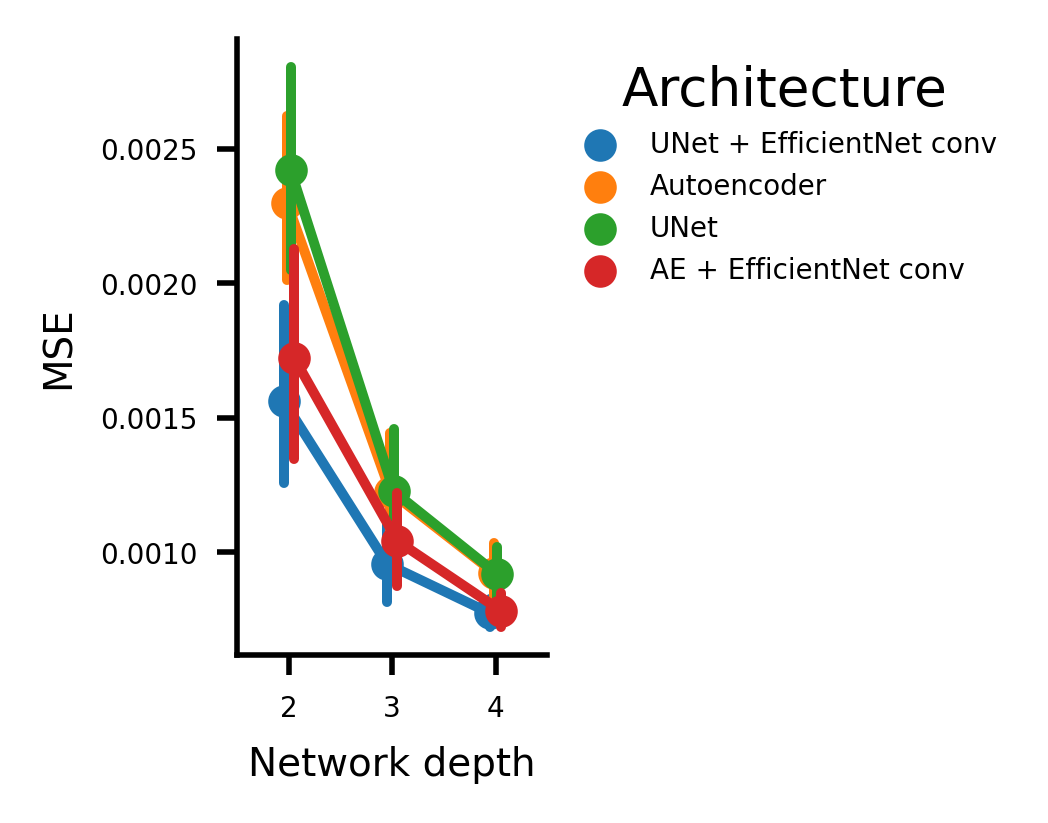

In [198]:
fig = plt.figure(figsize=(1, 2))
ax = sns.pointplot(data=results, x='depth', y='mse', hue='arch', dodge=True)
ax.set(xlabel='Network depth', ylabel='MSE')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, title='Architecture')
saver(fig, 'depth-vs-mse');

In [199]:
min_net = tmp.query('arch == "UNet + EfficientNet conv"')['param_count'].min()

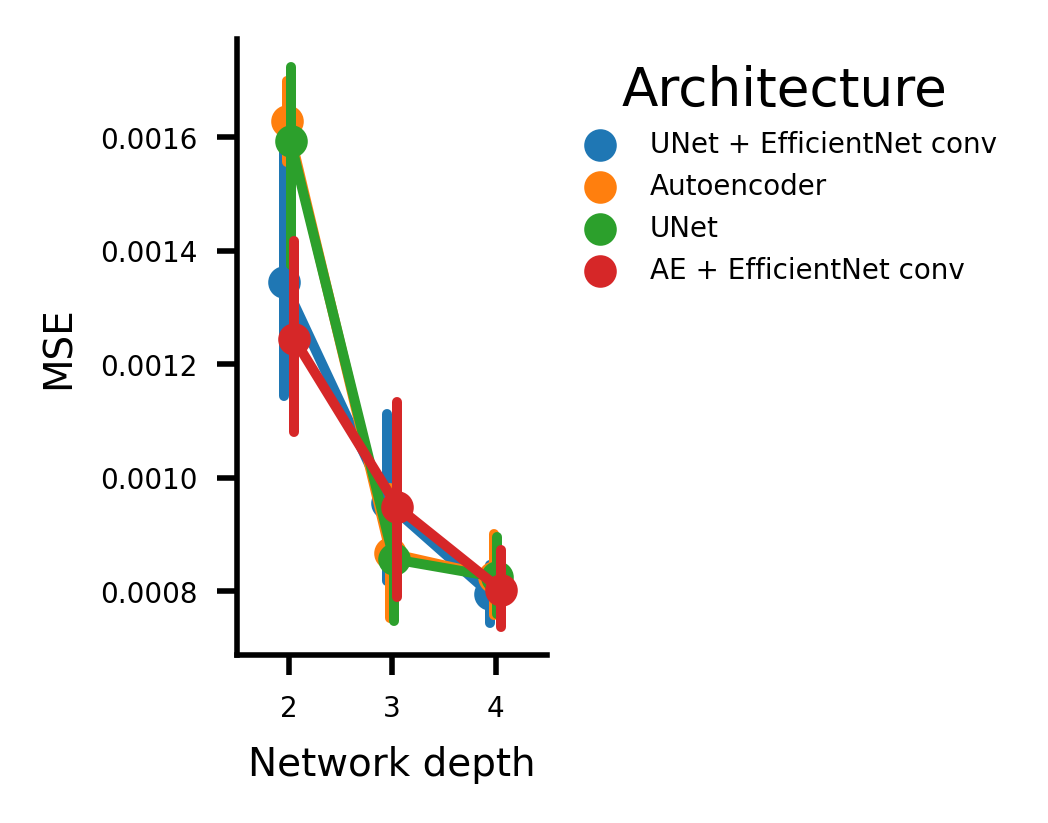

In [200]:
fig = plt.figure(figsize=(1, 2))
ax = sns.pointplot(data=tmp.query('param_count <= @max_unet & param_count > @min_net'), x='depth', y='mse', hue='arch', dodge=True)
ax.set(xlabel='Network depth', ylabel='MSE')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, title='Architecture')
# saver(fig, 'depth-vs-mse');

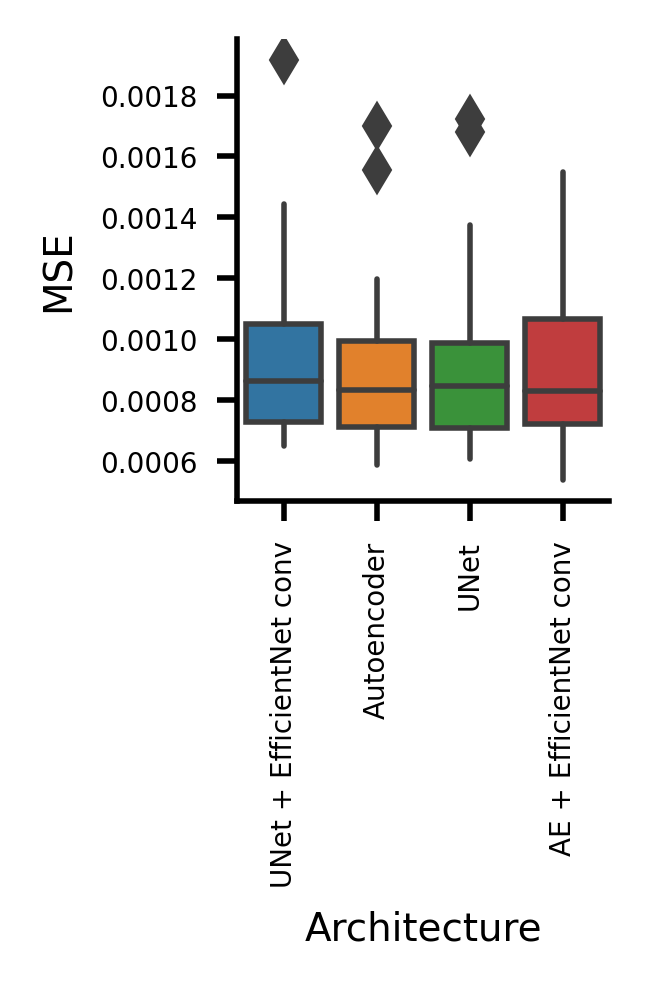

In [201]:
fig = plt.figure(figsize=(1.2, 1.5))
ax = sns.boxplot(data=tmp.query('param_count <= @max_unet & param_count > @min_net'), x='arch', y='mse', showcaps=False)
ax.set(xlabel='Architecture', ylabel='MSE')
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
sns.despine()
# saver(fig, 'arch-vs-mse');

In [62]:
# fig = plt.figure(figsize=(1.2, 1.5))
# ax = sns.boxplot(data=results, x='arch', y='fit_beh_val', showcaps=False)
# ax.set(xlabel='Architecture', ylabel='Behavior preservation r2')
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
# sns.despine()
# saver(fig, 'arch-vs-beh-preservation');

In [63]:
# fig = plt.figure(figsize=(1.2, 1.5))
# ax = sns.boxplot(data=results, x='arch', y='beh_mse', showcaps=False)
# ax.set(xlabel='Architecture', ylabel='Behavior preservation r2')
# ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)
# sns.despine()
# saver(fig, 'arch-vs-beh-preservation');

In [64]:
# ax = sns.pointplot(data=results, x='depth', y='beh_mse', hue='arch')
# ax.set(xlabel='Network depth', ylabel='Preservation of pose dynamics')
# sns.despine()

In [65]:
# ax = sns.lmplot(
#     data=results,
#     x="param_count",
#     y="beh_mse",
#     hue="arch",
#     logx=True,
#     scatter_kws=dict(lw=0, s=15),
#     height=2,
#     aspect=1,
#     fit_reg=False,
# )
# ax.set(
#     xscale="log",
#     ylabel="Preservation of pose dynamics (mse)", xlabel="Parameter count"
# )

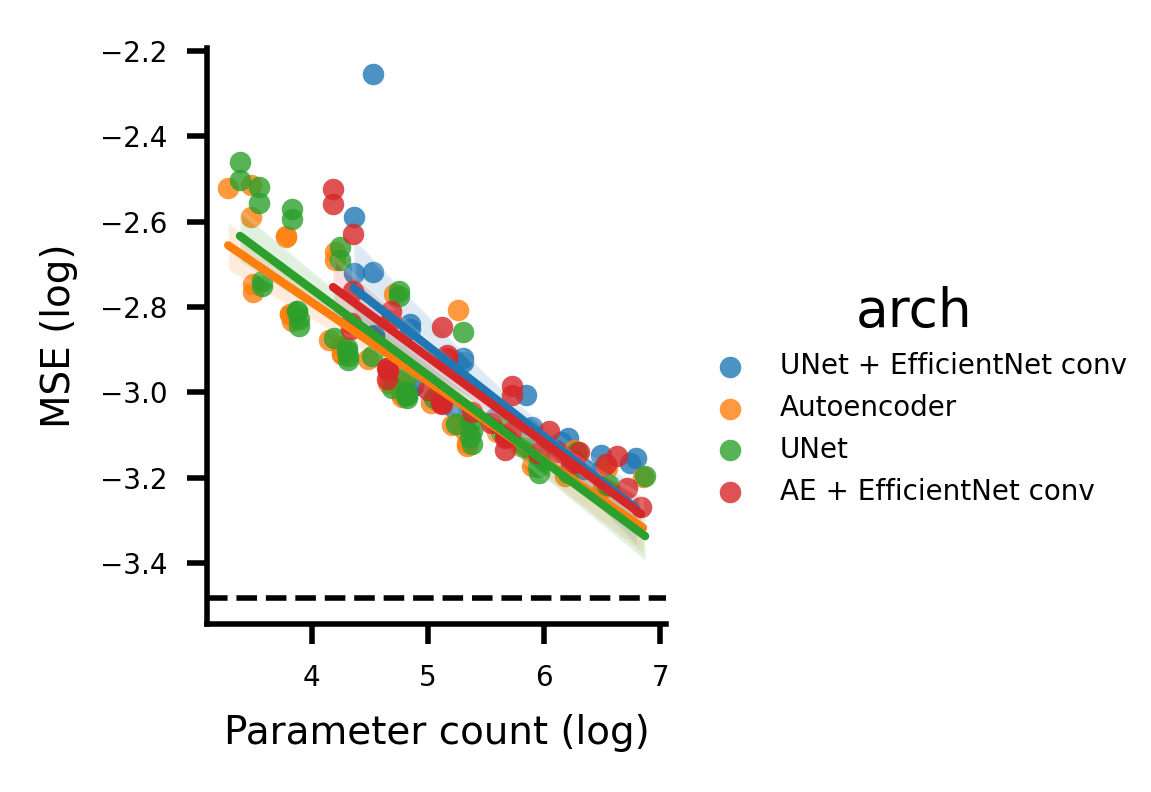

In [172]:
ax = sns.lmplot(
    data=tmp.query('param_count <= @max_unet'),
    x="params_log",
    y="mse_log",
    hue="arch",
    logx=False,
    scatter_kws=dict(lw=0, s=15),
    height=2,
    aspect=1,
)
ax.set(ylabel="MSE (log)", xlabel="Parameter count (log)",)
ax.ax.axhline(np.log10(lower_bound_loss), ls='--', c='k', label='Lower bound')
fig = plt.gcf()
# saver(fig, 'mse-vs-param-count');

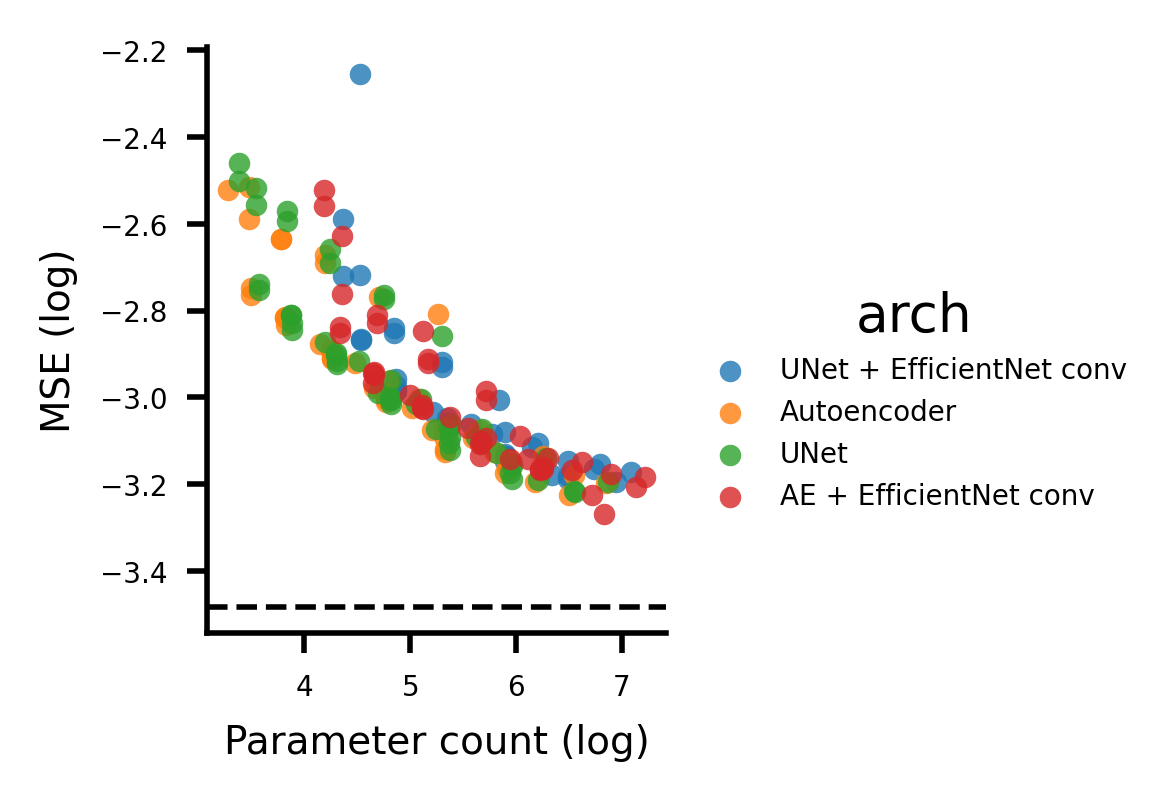

In [173]:
ax = sns.lmplot(
    # data=tmp.query("depth > 3"),
    data=tmp,
    x="params_log",
    y="mse_log",
    hue="arch",
    scatter_kws=dict(lw=0, s=15),
    height=2,
    aspect=1,
    fit_reg=False,
)
ax.set(
    ylabel="MSE (log)",
    xlabel="Parameter count (log)",
)
ax.ax.axhline(np.log10(lower_bound_loss), ls='--', c='k', label='Lower bound')
fig = plt.gcf()
# saver(fig, 'mse-vs-param-count');

In [174]:
tmp.sort_values(by='mse').head(n=20)

,depth,arch,channel_scaling,depth_scaling,init_depth,init_channel,mse,uuid,stopped,train_mse,epoch,param_count,file,mse_log,params_log
9,4,AE + EfficientNet conv,2.0,1.0,1,64,0.000540,11a53774-0222-46a5-8f70-37fadcef0f21,True,0.000448,233,6800000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.267969,6.832509
169,4,AE + EfficientNet conv,2.5,1.0,1,32,0.000595,643641bb-df9f-4338-aad4-79b9bcc22936,True,0.000509,199,5200000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.225449,6.716003
128,4,Autoencoder,2.0,1.0,1,128,0.000596,03a2bc9c-4e58-4670-bbe6-3567062f108d,True,0.000478,245,3200000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.225038,6.505150
189,4,UNet,3.5,1.0,1,32,0.000606,d87f69b0-0bb3-4c25-a729-6c6a22d0552d,True,0.000525,199,3600000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.217424,6.556303
106,4,UNet,2.0,1.0,1,128,0.000608,c8a4cca3-fade-4113-8e73-de20519f6e9f,True,0.000500,199,3500000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.216171,6.544068
194,4,AE + EfficientNet conv,3.0,1.0,1,32,0.000623,588c0536-5d0a-478b-8e1e-d85ef9ad2279,True,0.000520,199,13600000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.205685,7.133539
158,4,Autoencoder,4.0,1.0,1,32,0.000633,cd3bd9b5-28c2-4871-a69a-e51808eb9bcc,True,0.000527,199,7100000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.198357,6.851258
160,4,UNet + EfficientNet conv,2.5,1.0,1,32,0.000637,b8fb1676-96df-455b-989e-7fea8db89662,True,0.000539,199,8800000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.195858,6.944483
135,4,Autoencoder,3.0,1.0,1,32,0.000638,b2bcb09e-9999-479e-9bec-13fbc379ab6b,True,0.000555,199,1500000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.195383,6.176091
168,4,UNet,4.0,1.0,1,32,0.000638,38109a07-65b2-4dc9-837a-bafa395adf77,True,0.000528,199,7400000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.195092,6.869232


In [175]:
alpha = 1 - (1 / 13)
tmp['optim'] = tmp['mse_log'] * alpha + tmp['params_log'] * (1 - alpha)

In [176]:
tmp.sort_values(by='optim')

,depth,arch,channel_scaling,depth_scaling,init_depth,init_channel,mse,uuid,stopped,train_mse,epoch,param_count,file,mse_log,params_log,optim
9,4,AE + EfficientNet conv,2.0,1.0,1,64,0.000540,11a53774-0222-46a5-8f70-37fadcef0f21,True,0.000448,233,6800000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.267969,6.832509,-2.491009
69,4,UNet,2.0,1.0,1,64,0.000647,c8746363-fbb0-4cd7-9d41-9298895370e9,True,0.000543,199,909000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.189133,5.958564,-2.485464
128,4,Autoencoder,2.0,1.0,1,128,0.000596,03a2bc9c-4e58-4670-bbe6-3567062f108d,True,0.000478,245,3200000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.225038,6.505150,-2.476562
21,3,Autoencoder,2.0,1.0,1,128,0.000670,3caf92e5-842f-4819-8274-5e57234f3c90,True,0.000577,202,792000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.173776,5.898725,-2.475891
37,4,Autoencoder,2.0,1.0,1,32,0.000747,1a69e28e-2004-4ed2-b9dc-0e05f8b561a8,True,0.000636,251,215000.0,/n/groups/datta/win/longtogeny/size_norm/model...,-3.126584,5.332438,-2.475890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41,2,UNet,2.0,1.0,1,4,0.003149,5271817b-c4ac-482e-a45c-fb88e34cf69b,True,0.002846,199,2400.0,/n/groups/datta/win/longtogeny/size_norm/model...,-2.501854,3.380211,-2.049388
59,2,AE + EfficientNet conv,2.0,1.0,1,4,0.002760,e4cd5e56-808a-4462-8ade-475b99563a54,True,0.002535,199,15200.0,/n/groups/datta/win/longtogeny/size_norm/model...,-2.559069,4.181844,-2.040537
89,2,UNet,2.0,1.0,1,4,0.003466,92fb90e0-8299-4c08-b139-798791686252,True,0.003071,199,2400.0,/n/groups/datta/win/longtogeny/size_norm/model...,-2.460128,3.380211,-2.010871
84,2,AE + EfficientNet conv,2.0,1.0,1,4,0.003000,b0535e75-7d67-4fe6-88f7-05906aafaa2a,True,0.002666,199,15200.0,/n/groups/datta/win/longtogeny/size_norm/model...,-2.522822,4.181844,-2.007078


## Validation analysis

In [177]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 195
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depth            176 non-null    int64  
 1   arch             176 non-null    object 
 2   channel_scaling  176 non-null    float64
 3   depth_scaling    176 non-null    float64
 4   init_depth       176 non-null    int64  
 5   init_channel     176 non-null    int64  
 6   mse              176 non-null    float64
 7   uuid             176 non-null    object 
 8   stopped          176 non-null    bool   
 9   train_mse        176 non-null    float64
 10  epoch            176 non-null    int64  
 11  param_count      176 non-null    float64
 12  file             176 non-null    object 
dtypes: bool(1), float64(5), int64(4), object(3)
memory usage: 18.0+ KB


In [178]:
# ax = sns.lmplot(data=results, x='param_count', y='heldout_beh_val', hue='arch', logx=True)
# ax.set(xscale='log')

In [179]:
results.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176 entries, 0 to 195
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   depth            176 non-null    int64  
 1   arch             176 non-null    object 
 2   channel_scaling  176 non-null    float64
 3   depth_scaling    176 non-null    float64
 4   init_depth       176 non-null    int64  
 5   init_channel     176 non-null    int64  
 6   mse              176 non-null    float64
 7   uuid             176 non-null    object 
 8   stopped          176 non-null    bool   
 9   train_mse        176 non-null    float64
 10  epoch            176 non-null    int64  
 11  param_count      176 non-null    float64
 12  file             176 non-null    object 
dtypes: bool(1), float64(5), int64(4), object(3)
memory usage: 18.0+ KB


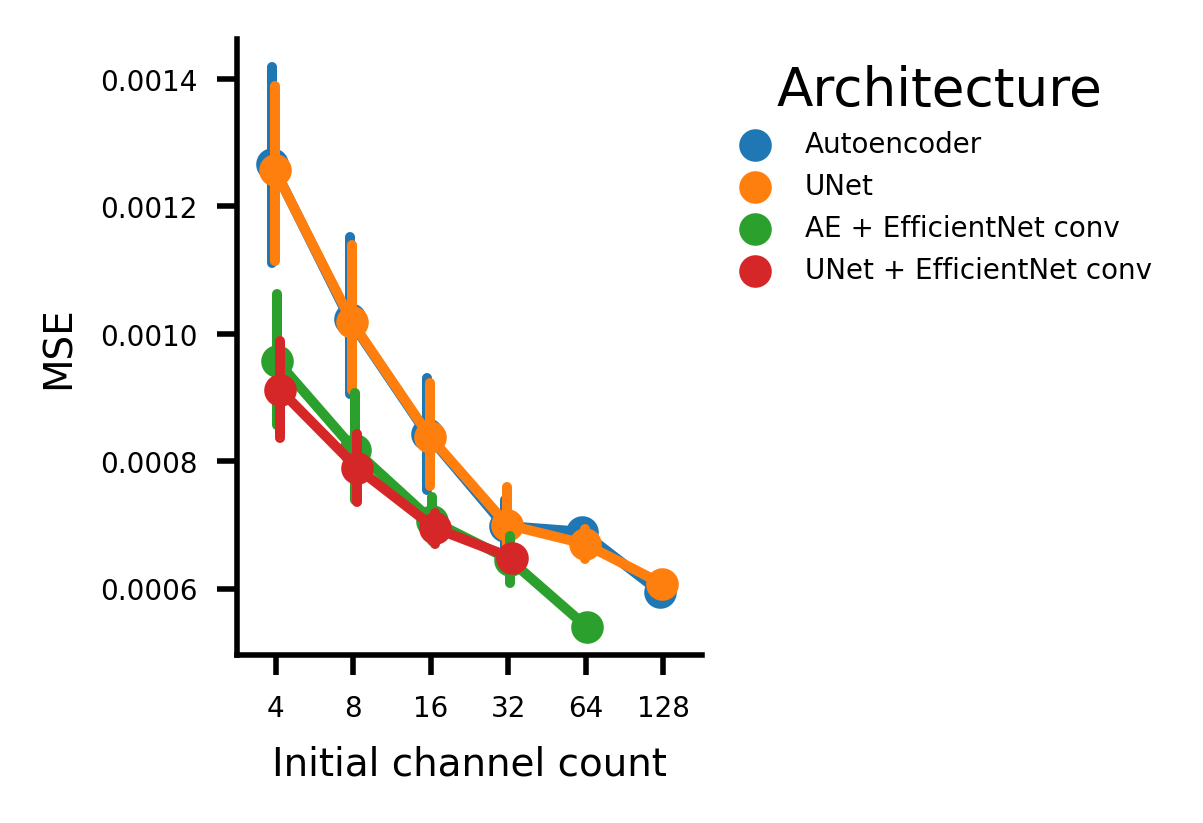

In [180]:
fig = plt.figure(figsize=(1.5, 2))
ax = sns.pointplot(data=tmp.query('depth == 4'), x='init_channel', y='mse', hue='arch', dodge=True)
ax.set(ylabel='MSE', xlabel='Initial channel count')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, title='Architecture')
# saver(fig, 'channel-count-vs-mse');

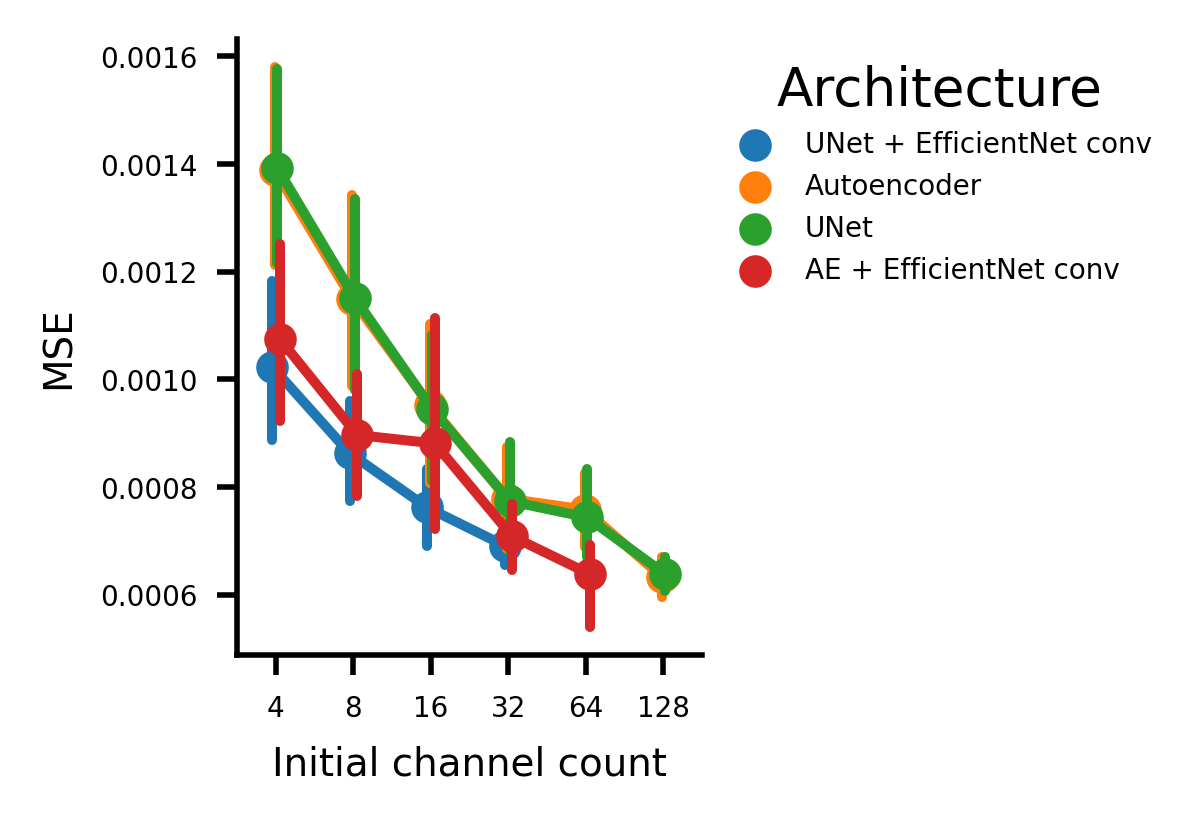

In [181]:
fig = plt.figure(figsize=(1.5, 2))
ax = sns.pointplot(data=tmp.query('param_count <= @max_unet & depth > 2'), x='init_channel', y='mse', hue='arch', dodge=True)
ax.set(ylabel='MSE', xlabel='Initial channel count')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, title='Architecture')
# saver(fig, 'channel-count-vs-mse');

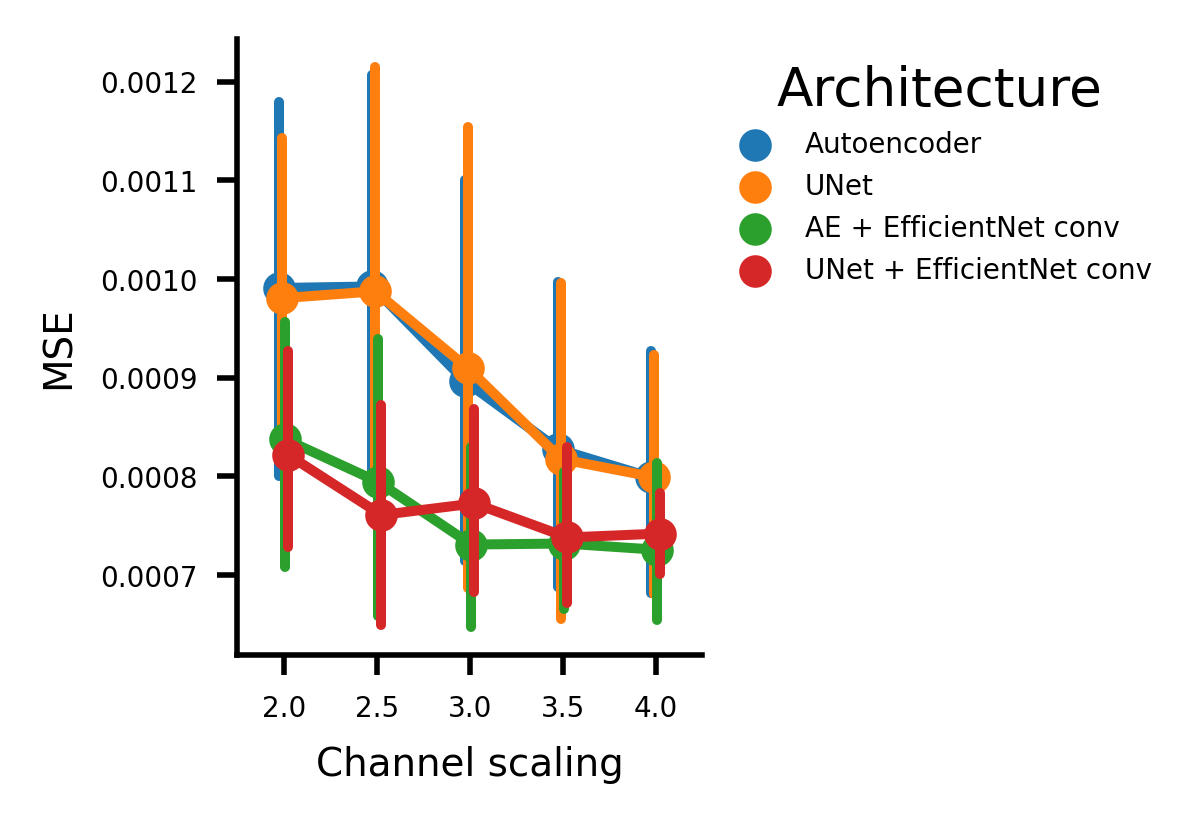

In [182]:
fig = plt.figure(figsize=(1.5, 2))
ax = sns.pointplot(data=tmp.query('depth == 4'), x='channel_scaling', y='mse', hue='arch', dodge=True)
ax.set(ylabel='MSE', xlabel='Channel scaling')
sns.despine()
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False, title='Architecture')
# saver(fig, 'channel-count-vs-mse');

In [183]:
# ax = sns.pointplot(data=results, x='init_channel', y='fit_beh_val', hue='arch')
# ax.set(ylabel='Preservation of pose dynamics', xlabel='Initial channel count')
# sns.despine()

In [184]:
tmp['channel_scaling'] = tmp['channel_scaling'].round(2)
tmp['depth_scaling'] = tmp['depth_scaling'].round(2)

[Text(13.749999999999995, 0.5, 'Architecture'),
 Text(0.5, -8.375000000000004, 'Initial channel count')]

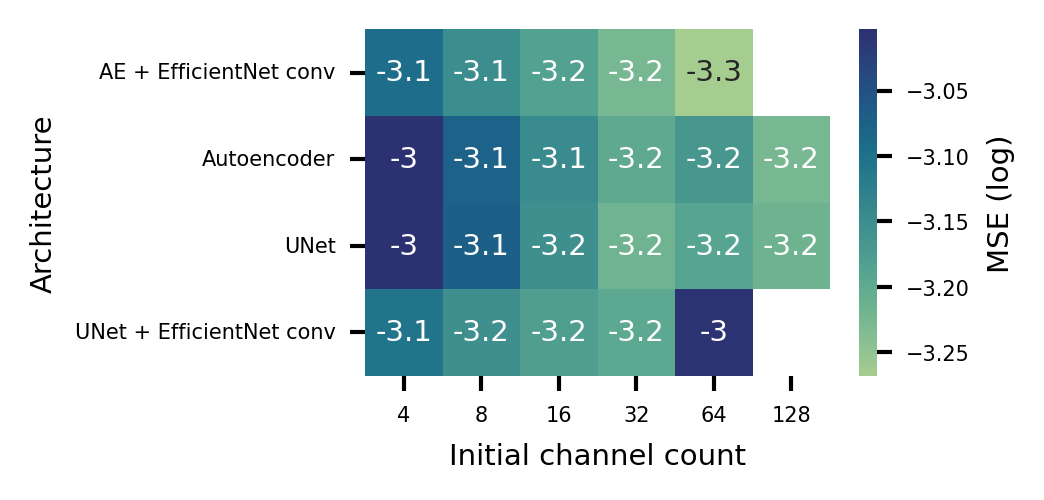

In [185]:
tbl = tmp.pivot_table(
    index="arch", columns="init_channel", values="mse_log", aggfunc="min"
)

# for arch in ('ae', 'unet', 'efficient'):
fig = plt.figure(figsize=(2.5, 1.5))
fig.dpi = 150
ax = sns.heatmap(
    tbl,
    annot=True,
    cmap="crest",
    vmin=tbl.min().min(),
    vmax=tbl.max().max(),
    cbar_kws=dict(label="MSE (log)"),
)
ax.set(ylabel="Architecture", xlabel="Initial channel count")
# saver(fig, "channel-count-vs-arch-heatmap-mse");

[Text(13.749999999999995, 0.5, 'Architecture'),
 Text(0.5, -8.375000000000004, 'Initial channel count')]

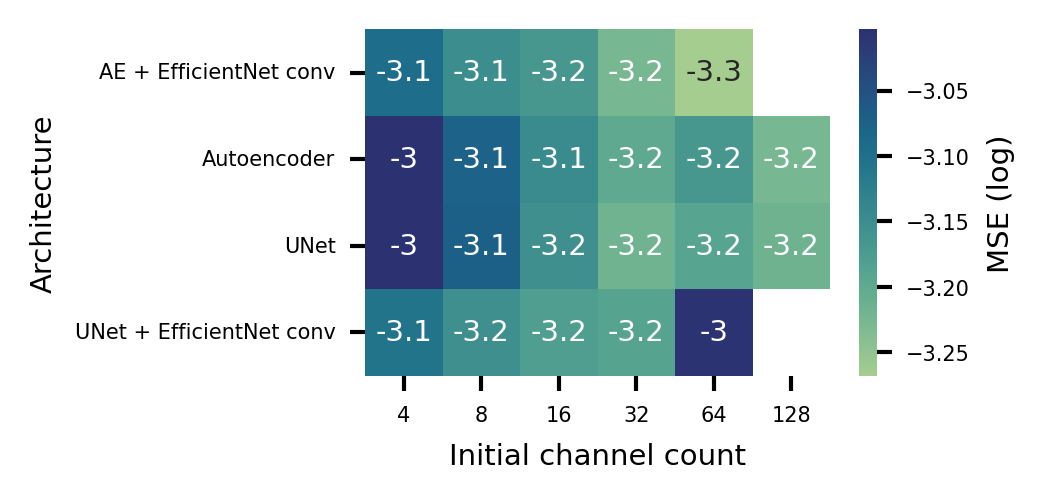

In [186]:
tbl = tmp.query('param_count <= @max_unet').pivot_table(
    index="arch", columns="init_channel", values="mse_log", aggfunc="min"
)

# for arch in ('ae', 'unet', 'efficient'):
fig = plt.figure(figsize=(2.5, 1.5))
fig.dpi = 150
ax = sns.heatmap(
    tbl,
    annot=True,
    cmap="crest",
    vmin=tbl.min().min(),
    vmax=tbl.max().max(),
    cbar_kws=dict(label="MSE (log)"),
)
ax.set(ylabel="Architecture", xlabel="Initial channel count")
# saver(fig, "channel-count-vs-arch-heatmap-mse");

[Text(13.749999999999995, 0.5, 'Architecture'),
 Text(0.5, -8.375000000000004, 'Depth')]

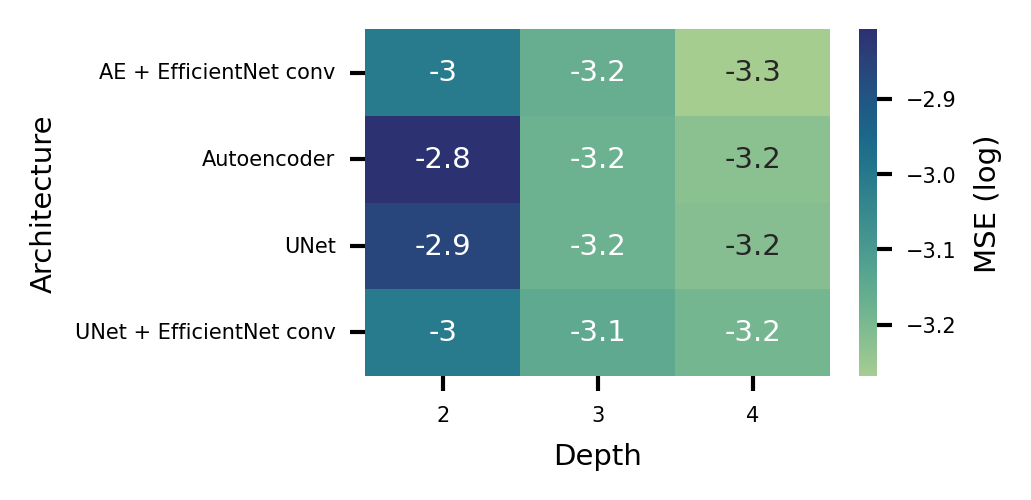

In [187]:
tbl = tmp.query('param_count <= @max_unet').pivot_table(
    index="arch", columns="depth", values="mse_log", aggfunc="min"
)

# for arch in ('ae', 'unet', 'efficient'):
fig = plt.figure(figsize=(2.5, 1.5))
fig.dpi = 150
ax = sns.heatmap(
    tbl,
    annot=True,
    cmap="crest",
    vmin=tbl.min().min(),
    vmax=tbl.max().max(),
    cbar_kws=dict(label="MSE (log)"),
)
ax.set(ylabel="Architecture", xlabel="Depth")
# saver(fig, "channel-count-vs-arch-heatmap-mse");

In [80]:
# tbl = results.pivot_table(
#     index="arch", columns="init_channel", values="fit_beh_val", aggfunc="mean"
# )

# # for arch in ('ae', 'unet', 'efficient'):
# fig = plt.figure(figsize=(2.5, 1.5))
# fig.dpi = 150
# ax = sns.heatmap(
#     tbl,
#     annot=True,
#     cmap="crest_r",
#     vmin=tbl.min().min(),
#     vmax=tbl.max().max(),
#     cbar_kws=dict(label="Behavior preservation r2"),
# )
# ax.set(ylabel='Architecture', xlabel='Initial channel count')
# saver(fig, 'channel-count-vs-arch-heatmap-behavior-preservation');

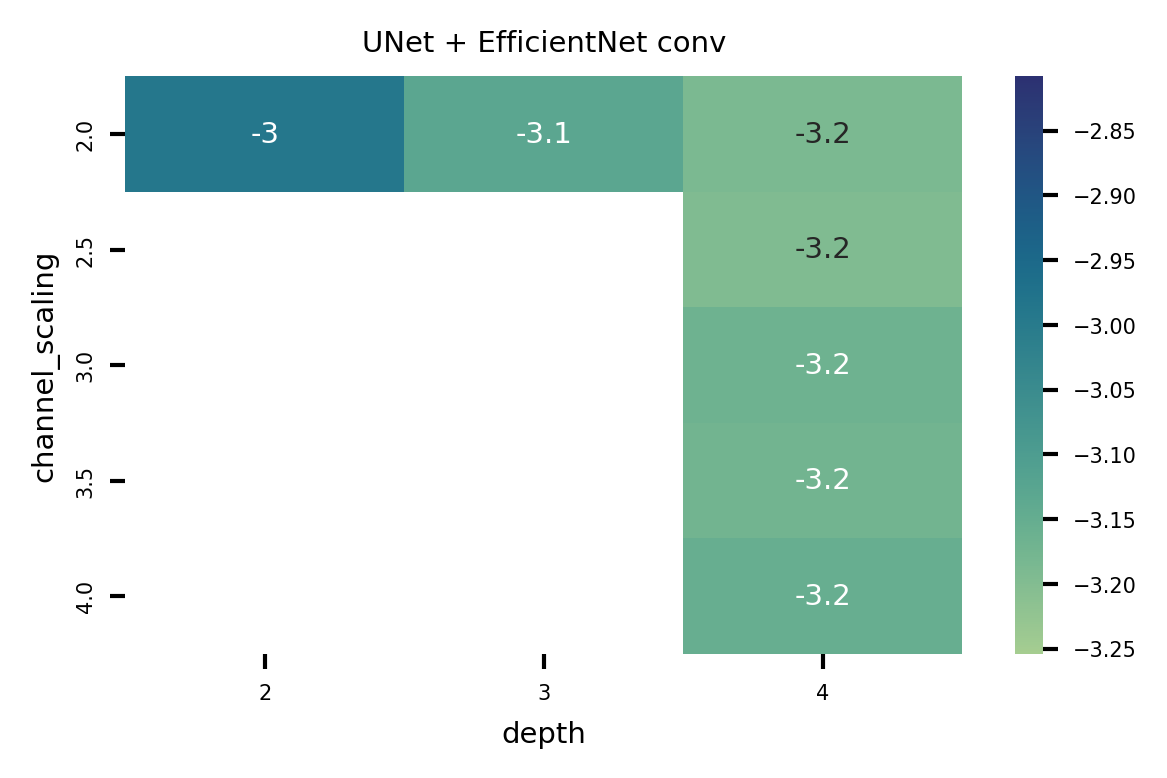

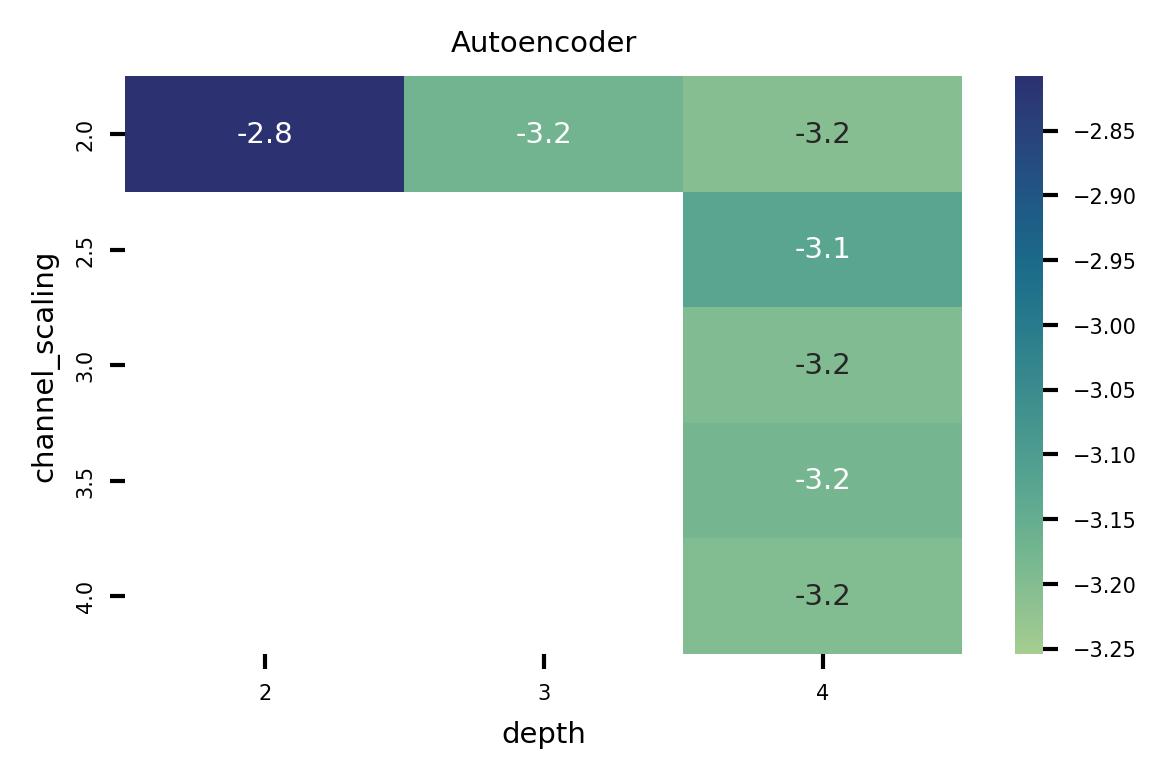

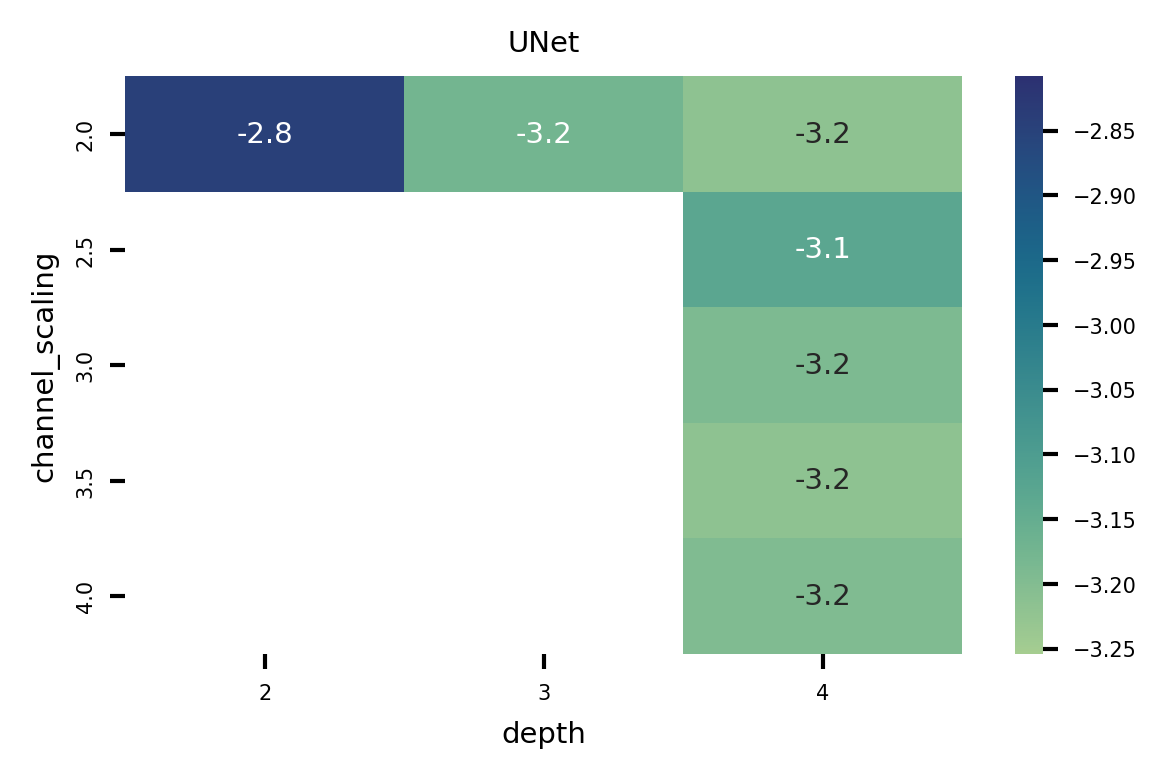

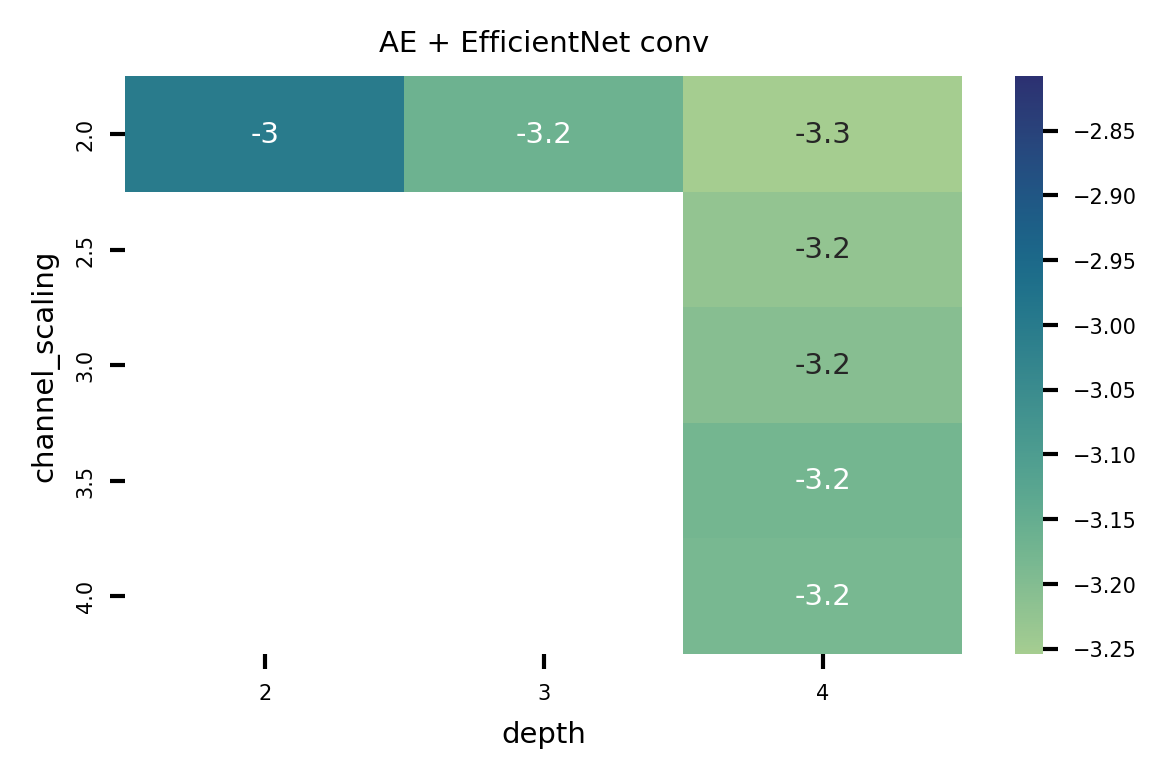

In [159]:
archs = tmp['arch'].unique()
tbl = tmp.pivot_table(index=['arch', 'channel_scaling'], columns='depth', values='mse_log', aggfunc='min')

for arch in archs:
    fig = plt.figure(figsize=(4.5, 2.5))
    fig.dpi = 150
    ax = sns.heatmap(tbl.loc[arch], annot=True, cmap='crest', vmin=tbl.min().min(), vmax=tbl.max().max())
    ax.set_title(arch)

## Validation r2's

In [66]:
# tbl = results.pivot_table(index=['arch', 'channel_scaling'], columns='init_channel', values='fit_beh_val')

# for arch in ('ae', 'unet', 'efficient'):
#     fig = plt.figure(figsize=(4.5, 2.5))
#     fig.dpi = 150
#     ax = sns.heatmap(tbl.loc[arch], annot=True, cmap='crest_r', vmin=tbl.min().min(), vmax=tbl.max().max())
#     ax.set_title(arch)

## Compare model classification accuracy w/ + w/o age regularization

#### Without

In [3]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/test_classifier_without_adversarial')

In [8]:
out = pd.read_csv(folder / "size_norm_scan/version_0/metrics.csv")

In [11]:
out[['epoch', 'age_classification']].dropna()

,epoch,age_classification
163,15,0.254785
318,30,0.207970


#### With

In [12]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/test_classifier_with_adversarial')

In [15]:
out = pd.read_csv(folder / "size_norm_scan/version_0/metrics.csv")

In [16]:
out[['epoch', 'age_classification']].dropna()

,epoch,age_classification
163,15,0.230696
318,30,0.217630


#### With adversarial classifier

In [17]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/test_classifier_with_adversarial_classifier')

In [20]:
out = pd.read_csv(folder / "size_norm_scan/version_0/metrics.csv")

In [21]:
out[['epoch', 'age_classification']].dropna()

,epoch,age_classification
163,15,0.253748
318,30,0.173541


#### With adversarial nonlinear regression

In [22]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/test_classifier_with_adversarial_nonlin')

In [23]:
out = pd.read_csv(folder / "size_norm_scan/version_0/metrics.csv")

In [24]:
out[['epoch', 'age_classification']].dropna()

,epoch,age_classification
163,15,0.236207
318,30,0.188622


In [27]:
out = pd.read_csv(folder / "size_norm_scan/version_2/metrics.csv")

In [31]:
out[['epoch', 'age_classification']].dropna()

,epoch,age_classification
163,15,0.258104
318,30,0.392000


,train_loss,scale_factor,class_loss,step,val_loss,age_classification
epoch,,,,,,
0,0.027450,0.00,0.914478,270.200000,0.004211,NaN
1,0.003505,0.00,0.907194,721.400000,0.002622,NaN
2,0.002955,0.00,0.732863,1172.600000,0.002074,NaN
3,0.002463,0.00,0.653729,1623.800000,0.002044,NaN
4,0.001920,0.00,0.637944,2095.363636,0.001838,NaN
5,0.001772,0.00,0.647043,2571.200000,0.001780,NaN
6,0.001819,0.00,0.684673,3022.400000,0.001718,NaN
7,0.001604,0.00,0.719446,3473.600000,0.001672,NaN
8,0.001562,0.00,0.661551,3945.181818,0.001548,NaN


<Axes: xlabel='scale_factor', ylabel='train_loss'>

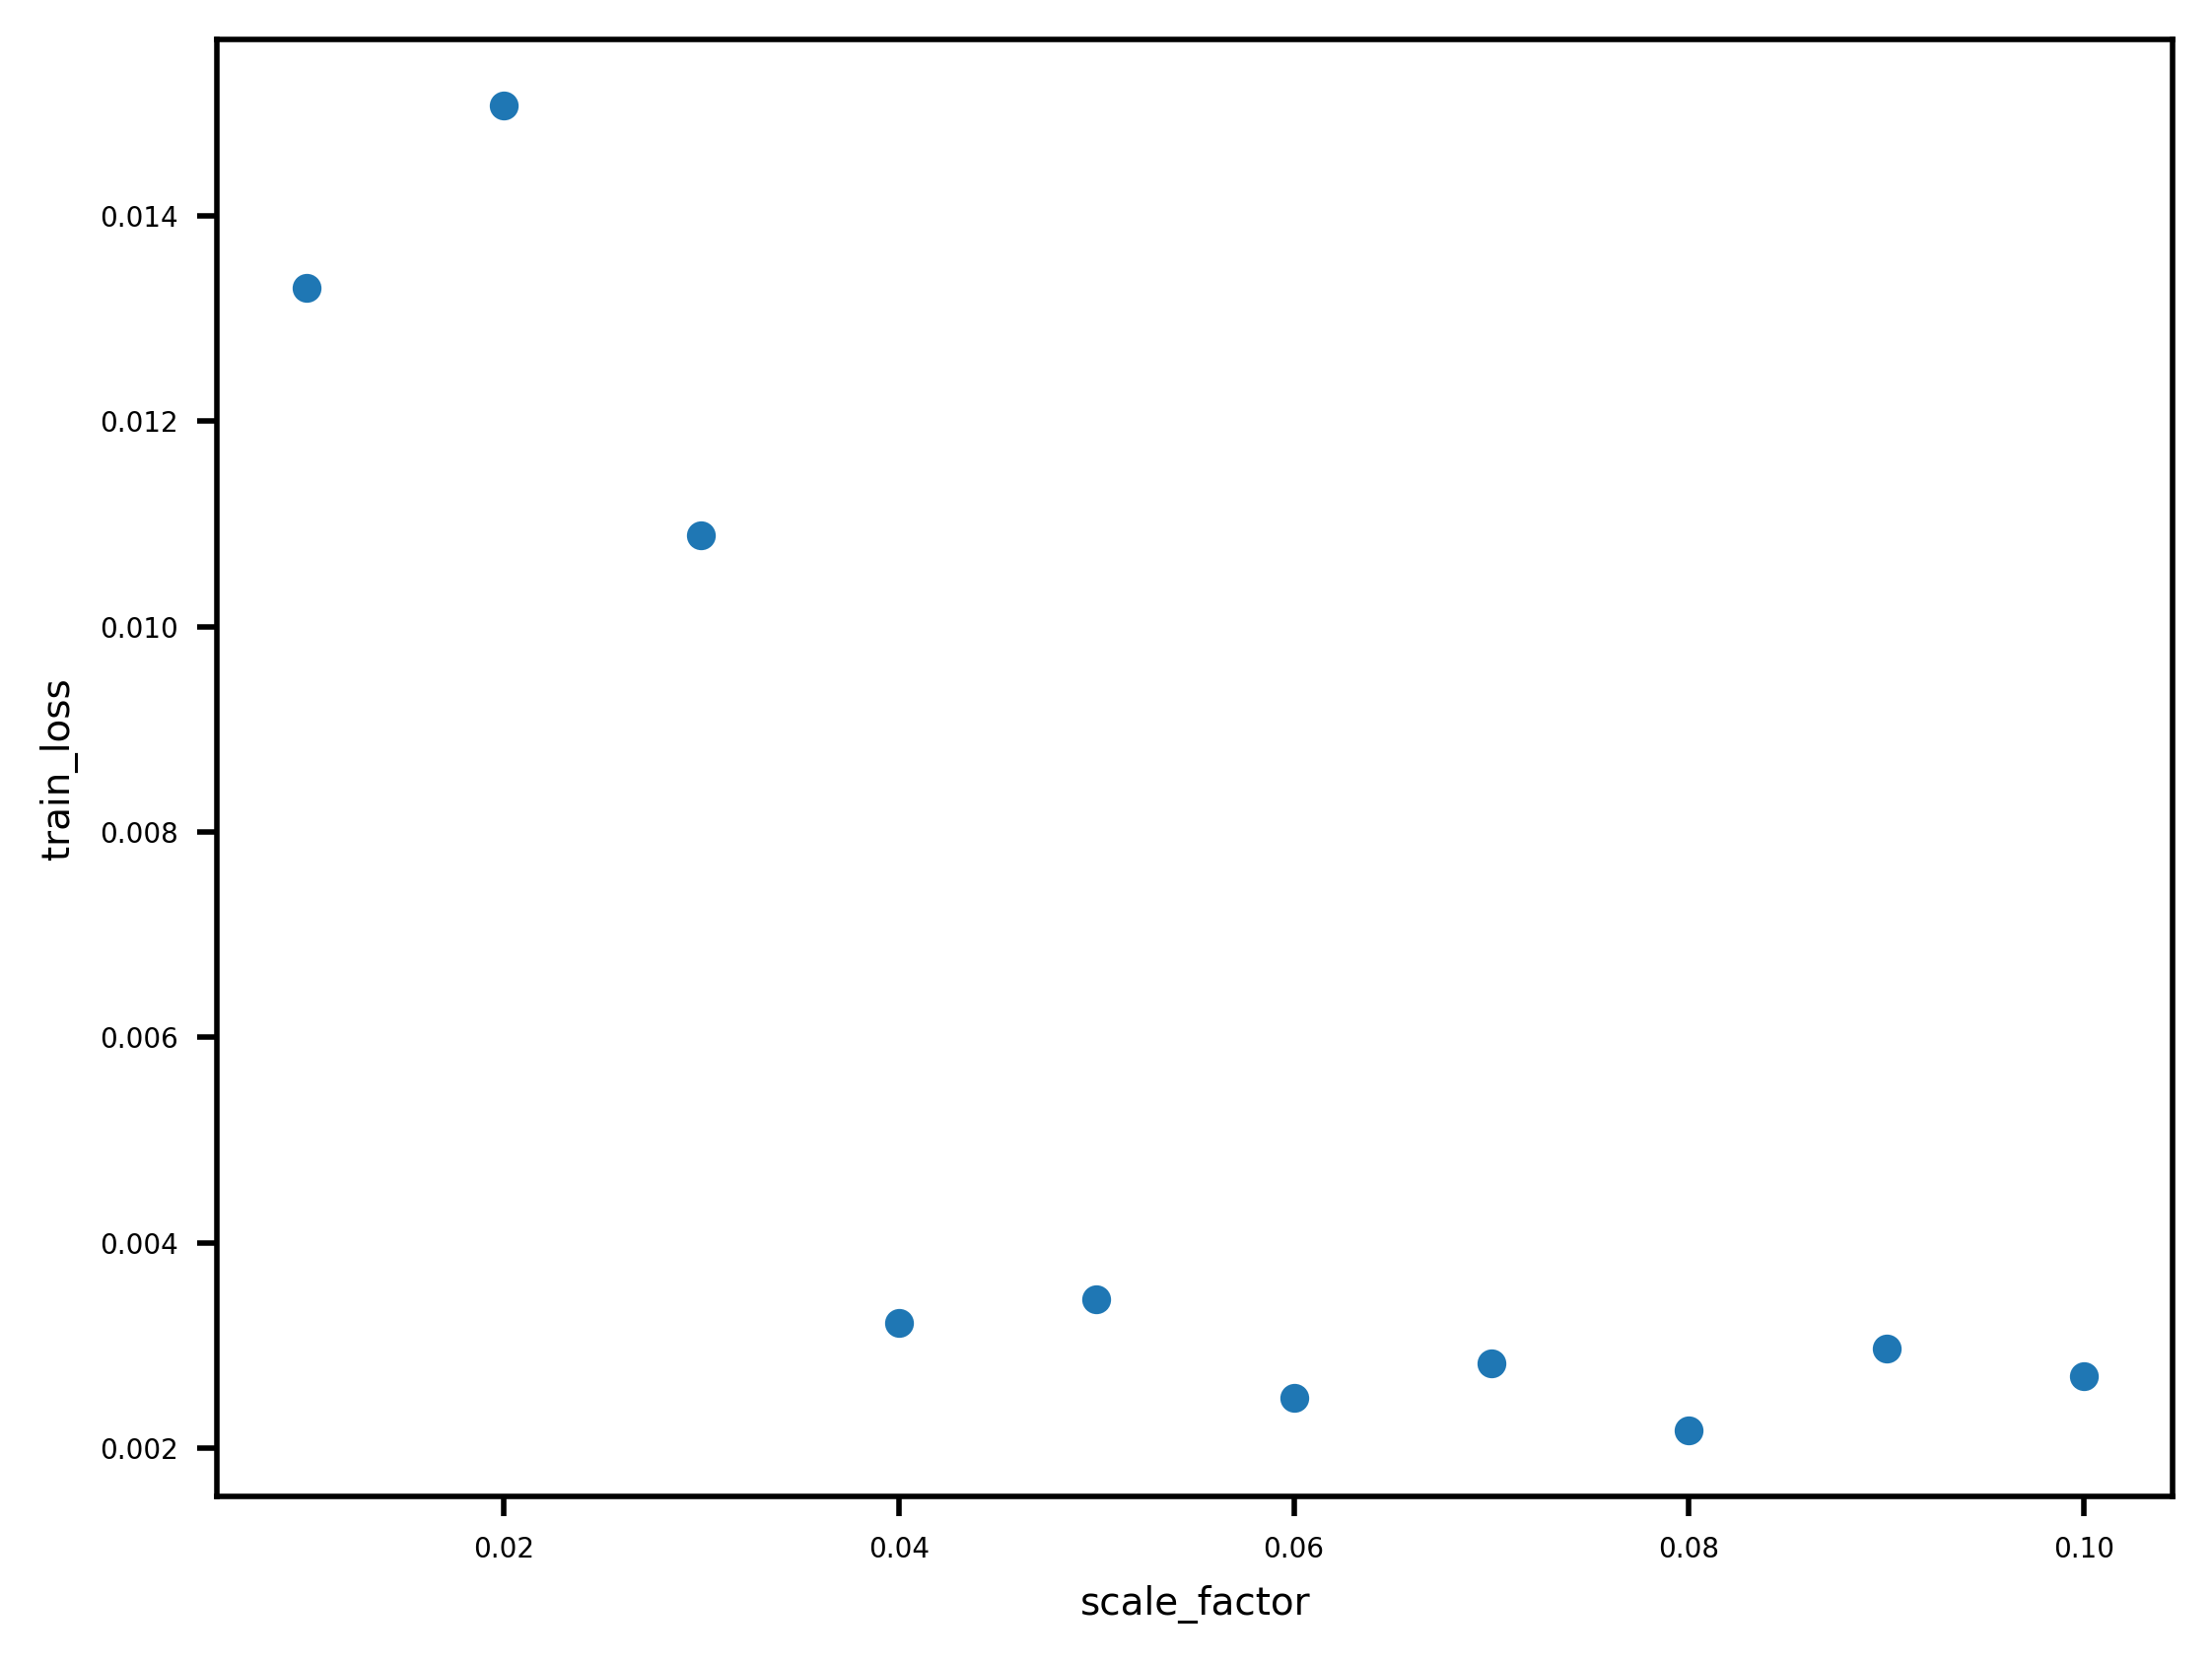

In [47]:
tmp = out.groupby('epoch').mean()
tmp.query('scale_factor > 0').plot(kind='scatter', x='scale_factor', y='train_loss')

<Axes: xlabel='scale_factor', ylabel='val_loss'>

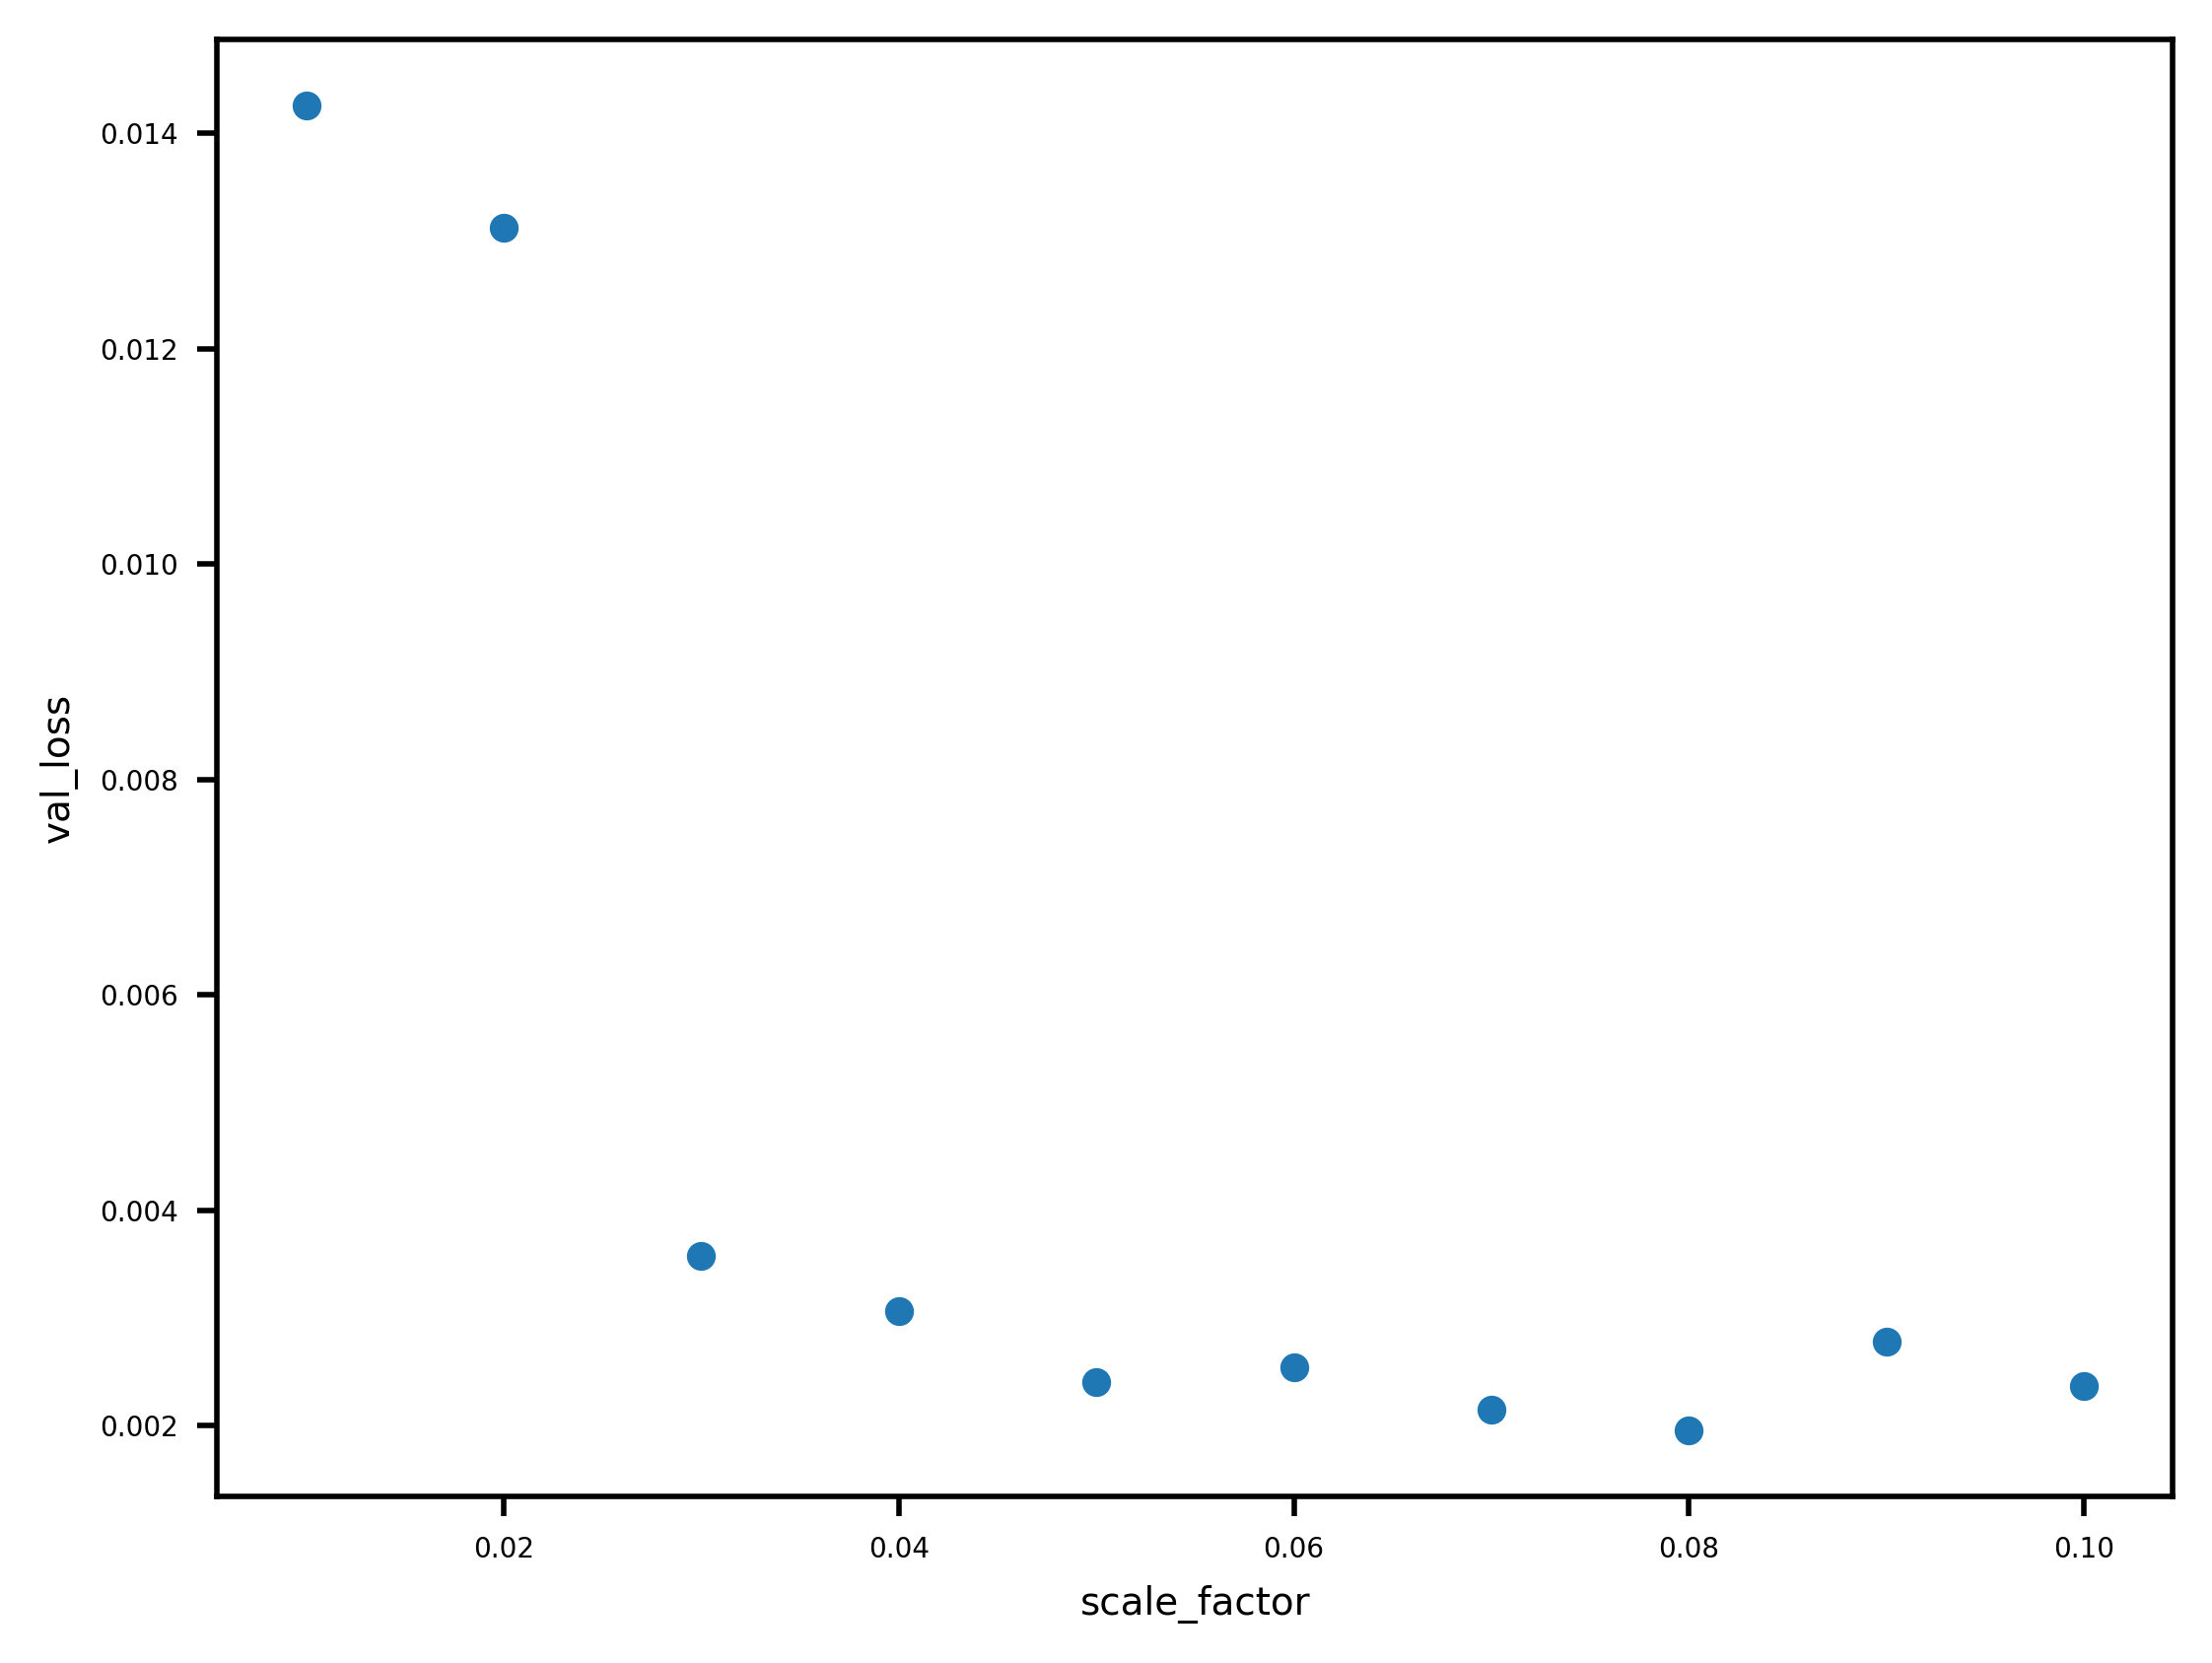

In [46]:
tmp = out.groupby('epoch').mean()
tmp.query('scale_factor > 0').plot(kind='scatter', x='scale_factor', y='val_loss')

<Axes: xlabel='epoch'>

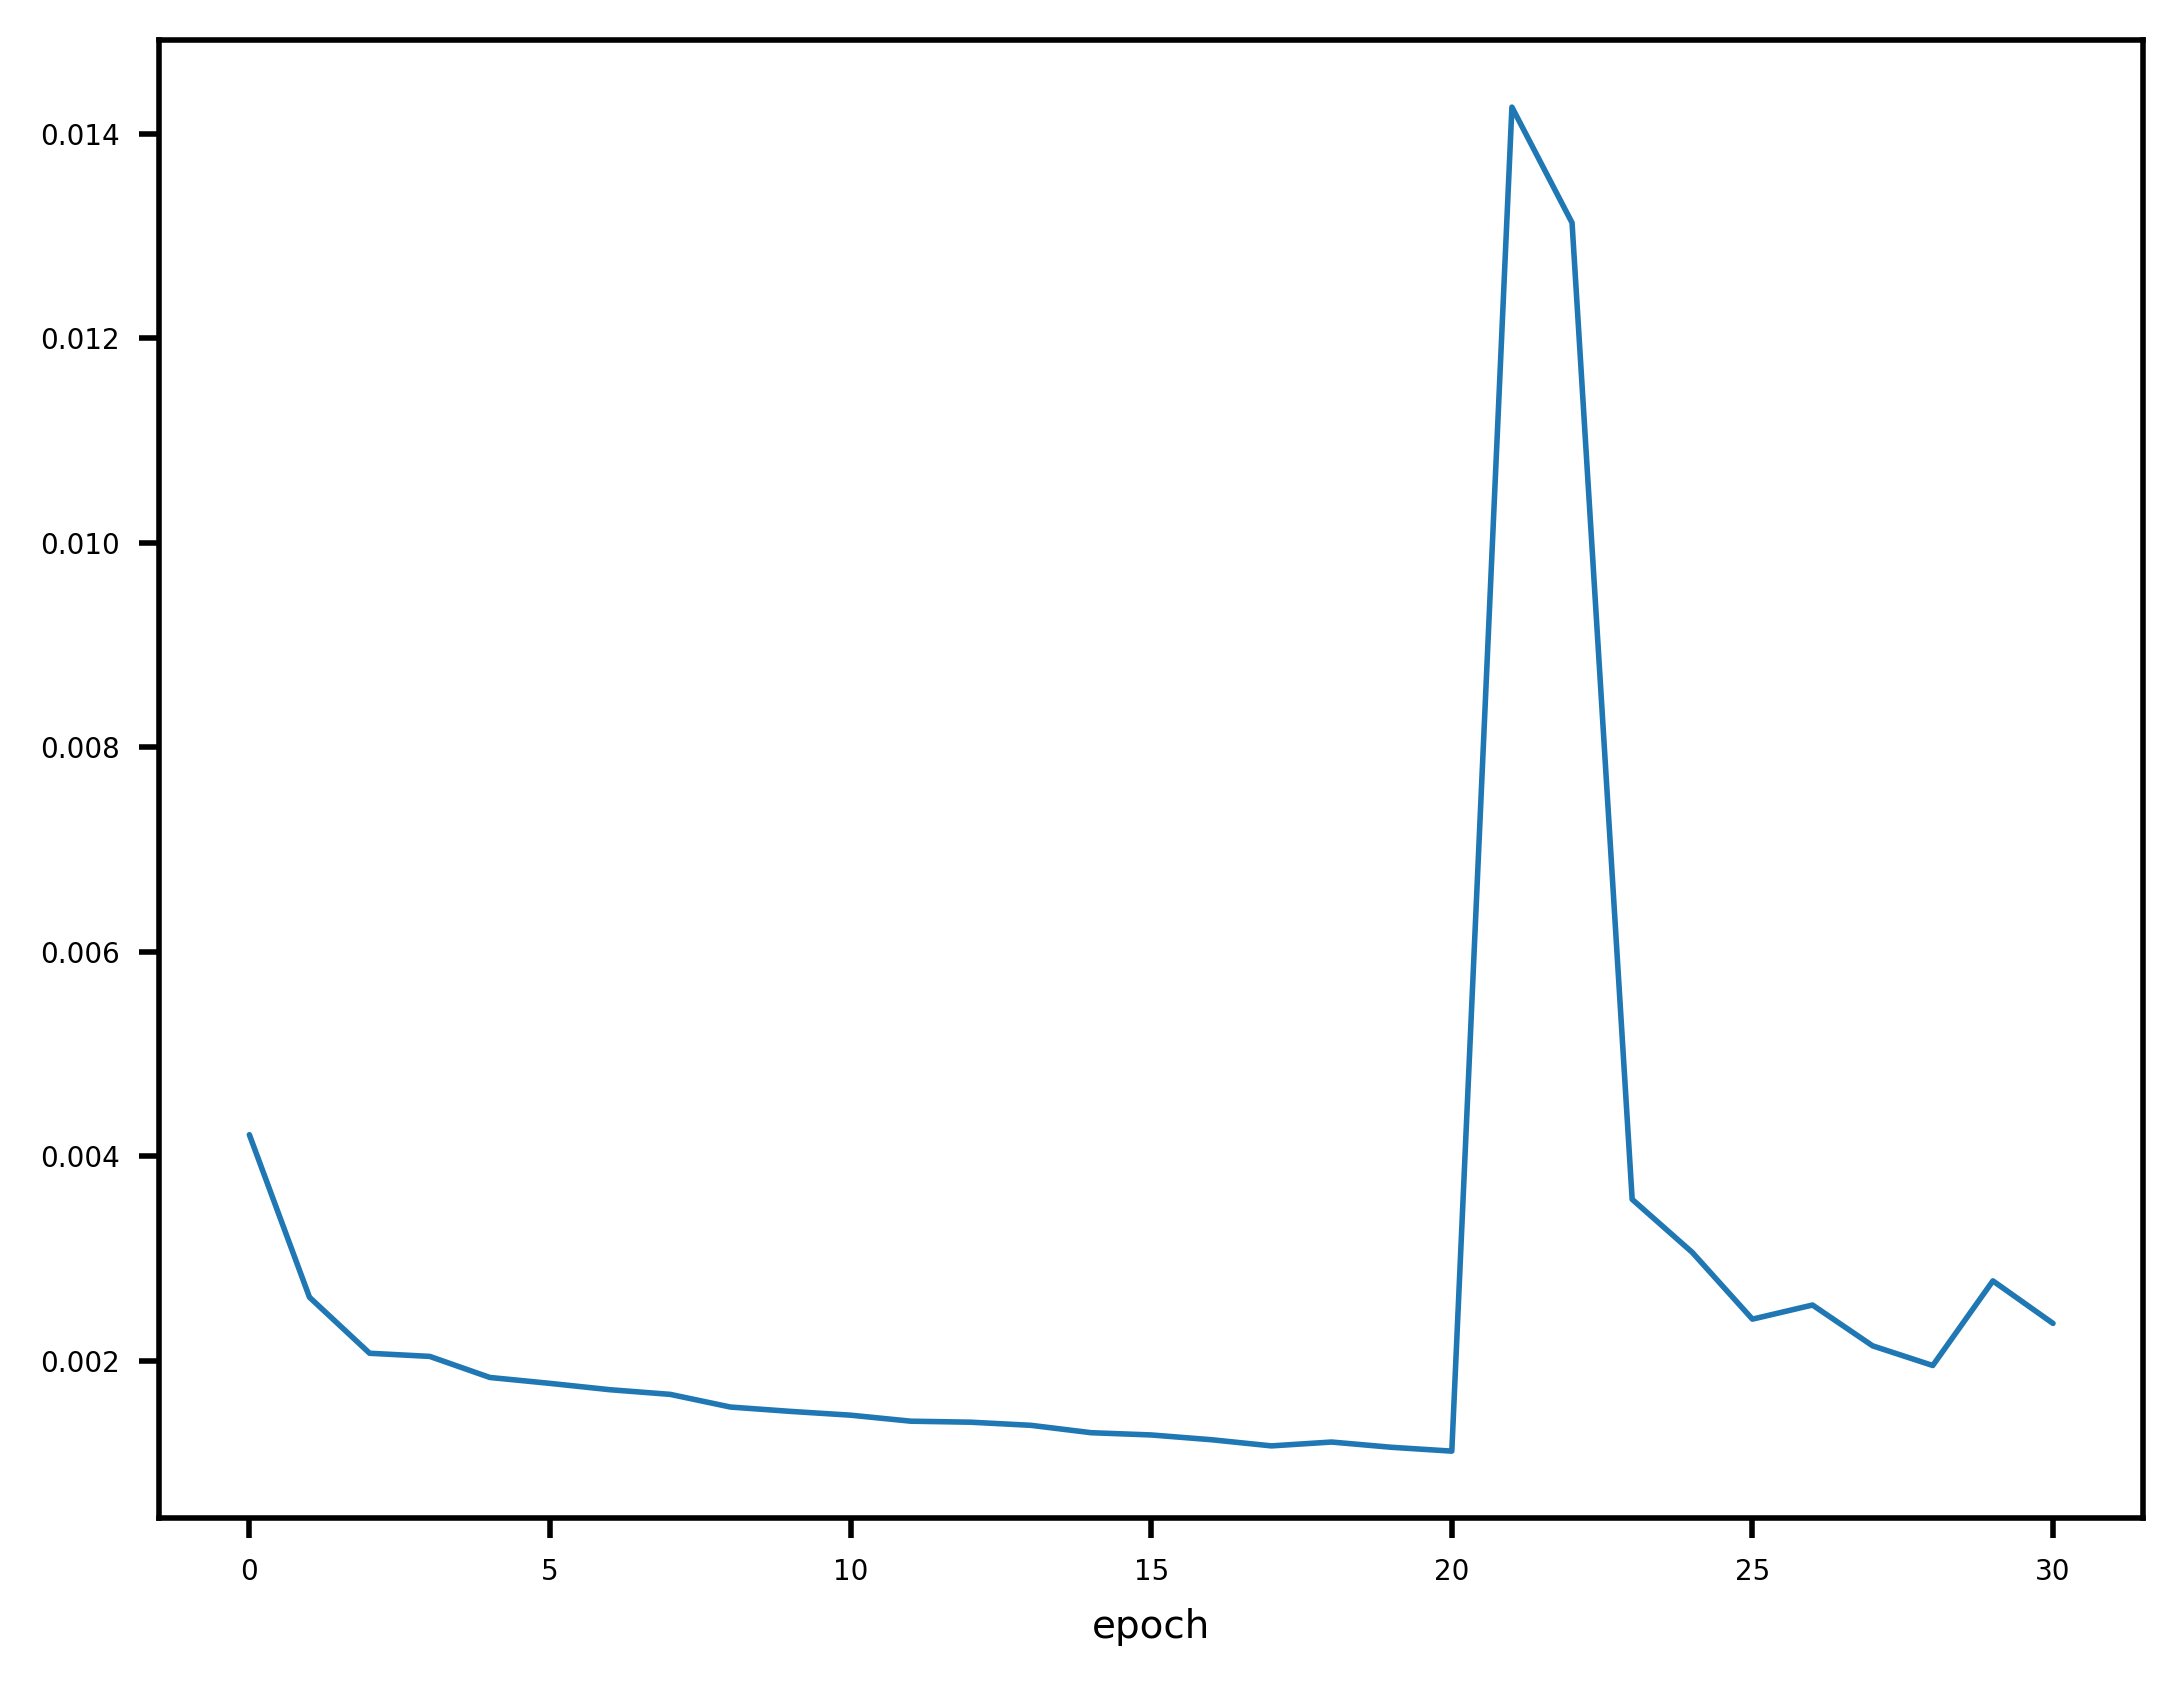

In [48]:
tmp['val_loss'].plot()

## Compare model classification accuracy w/ + w/o age regularization - parameter scan

In [247]:
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/adversarial_performance_scan_00/')

In [270]:
files = list(folder.glob('**/metrics.csv'))

In [454]:
dfs = {}
params = {}
for f in files:
    dfs[f] = pd.read_csv(f)
    params[f] = toml.load(f.parents[2] / "config.toml")

In [487]:
k = list(dfs)[2]
df = dfs[k]
tmp = df.groupby('epoch').mean()

p = params[k]
p['model']['lightning']

{'adversarial_prob': 0.01,
 'lr': 0.001,
 'weight_decay': 1e-05,
 'arch': 'ae',
 'train_adversarial': True,
 'adversarial_age_lr': 0.001,
 'jit': True,
 'adversarial_arch': 'linear',
 'adversarial_type': 'continuous',
 'lr_scheduler_params': {'patience': 70},
 'adversarial_age_scaling': {'start_epoch': 10,
  'start_value': 1e-07,
  'max_value': 1,
  'epochs_to_max': 50}}

In [475]:
tmp

,train_loss,scale_factor,class_loss,class_acc,step,val_loss,age_classification,dynamics_correlation
epoch,,,,,,,,
0,0.027601,0.0,2.168413,0.147569,270.200000,0.004155,NaN,NaN
1,0.003712,0.0,2.164636,0.137153,721.400000,0.002429,NaN,NaN
2,0.002156,0.0,2.143277,0.161458,1172.600000,0.002100,NaN,NaN
3,0.002329,0.0,2.137592,0.180556,1623.800000,0.001802,NaN,NaN
4,0.001720,0.0,2.144577,0.156250,2095.363636,0.001694,NaN,NaN
...,...,...,...,...,...,...,...,...
66,0.021497,1.0,2.783757,0.121875,30744.818182,0.017854,NaN,NaN
67,0.061435,1.0,2.881770,0.093750,31220.600000,0.016209,NaN,NaN
68,0.016202,1.0,2.648271,0.109375,31671.800000,0.017427,NaN,NaN


<Axes: xlabel='epoch'>

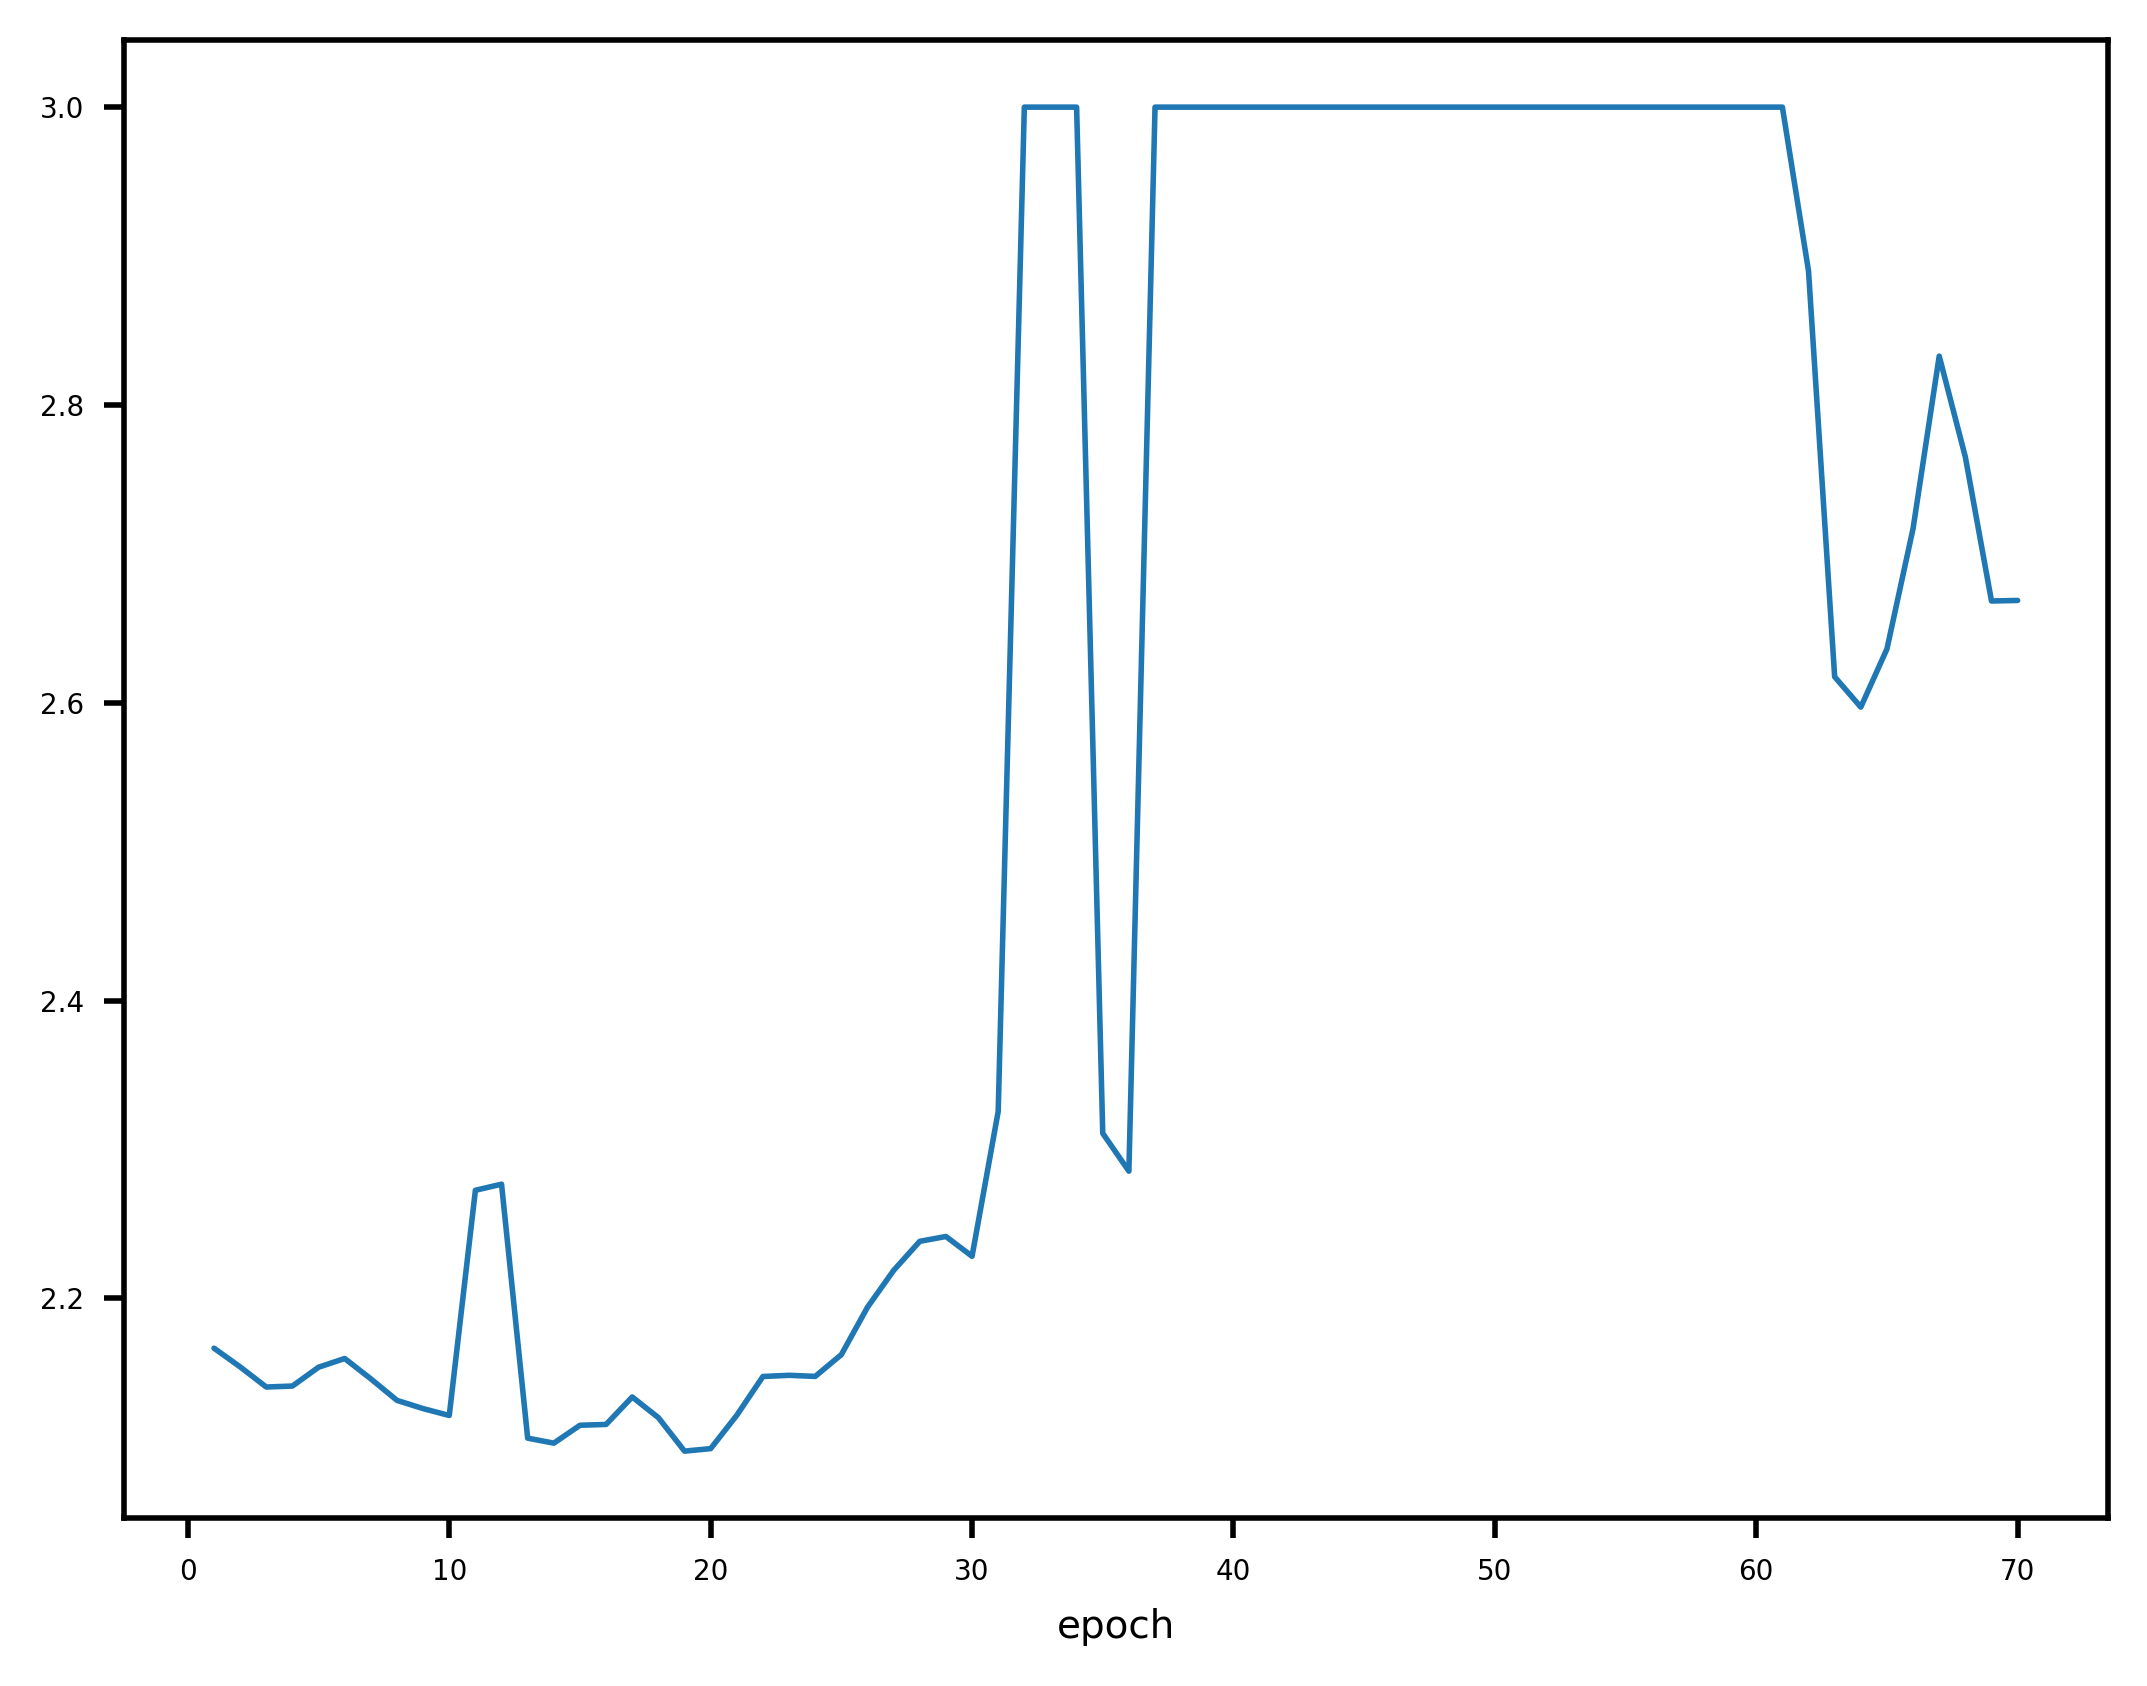

In [476]:
tmp['class_loss'].rolling(2).mean().clip(upper=3).plot()

<Axes: xlabel='epoch'>

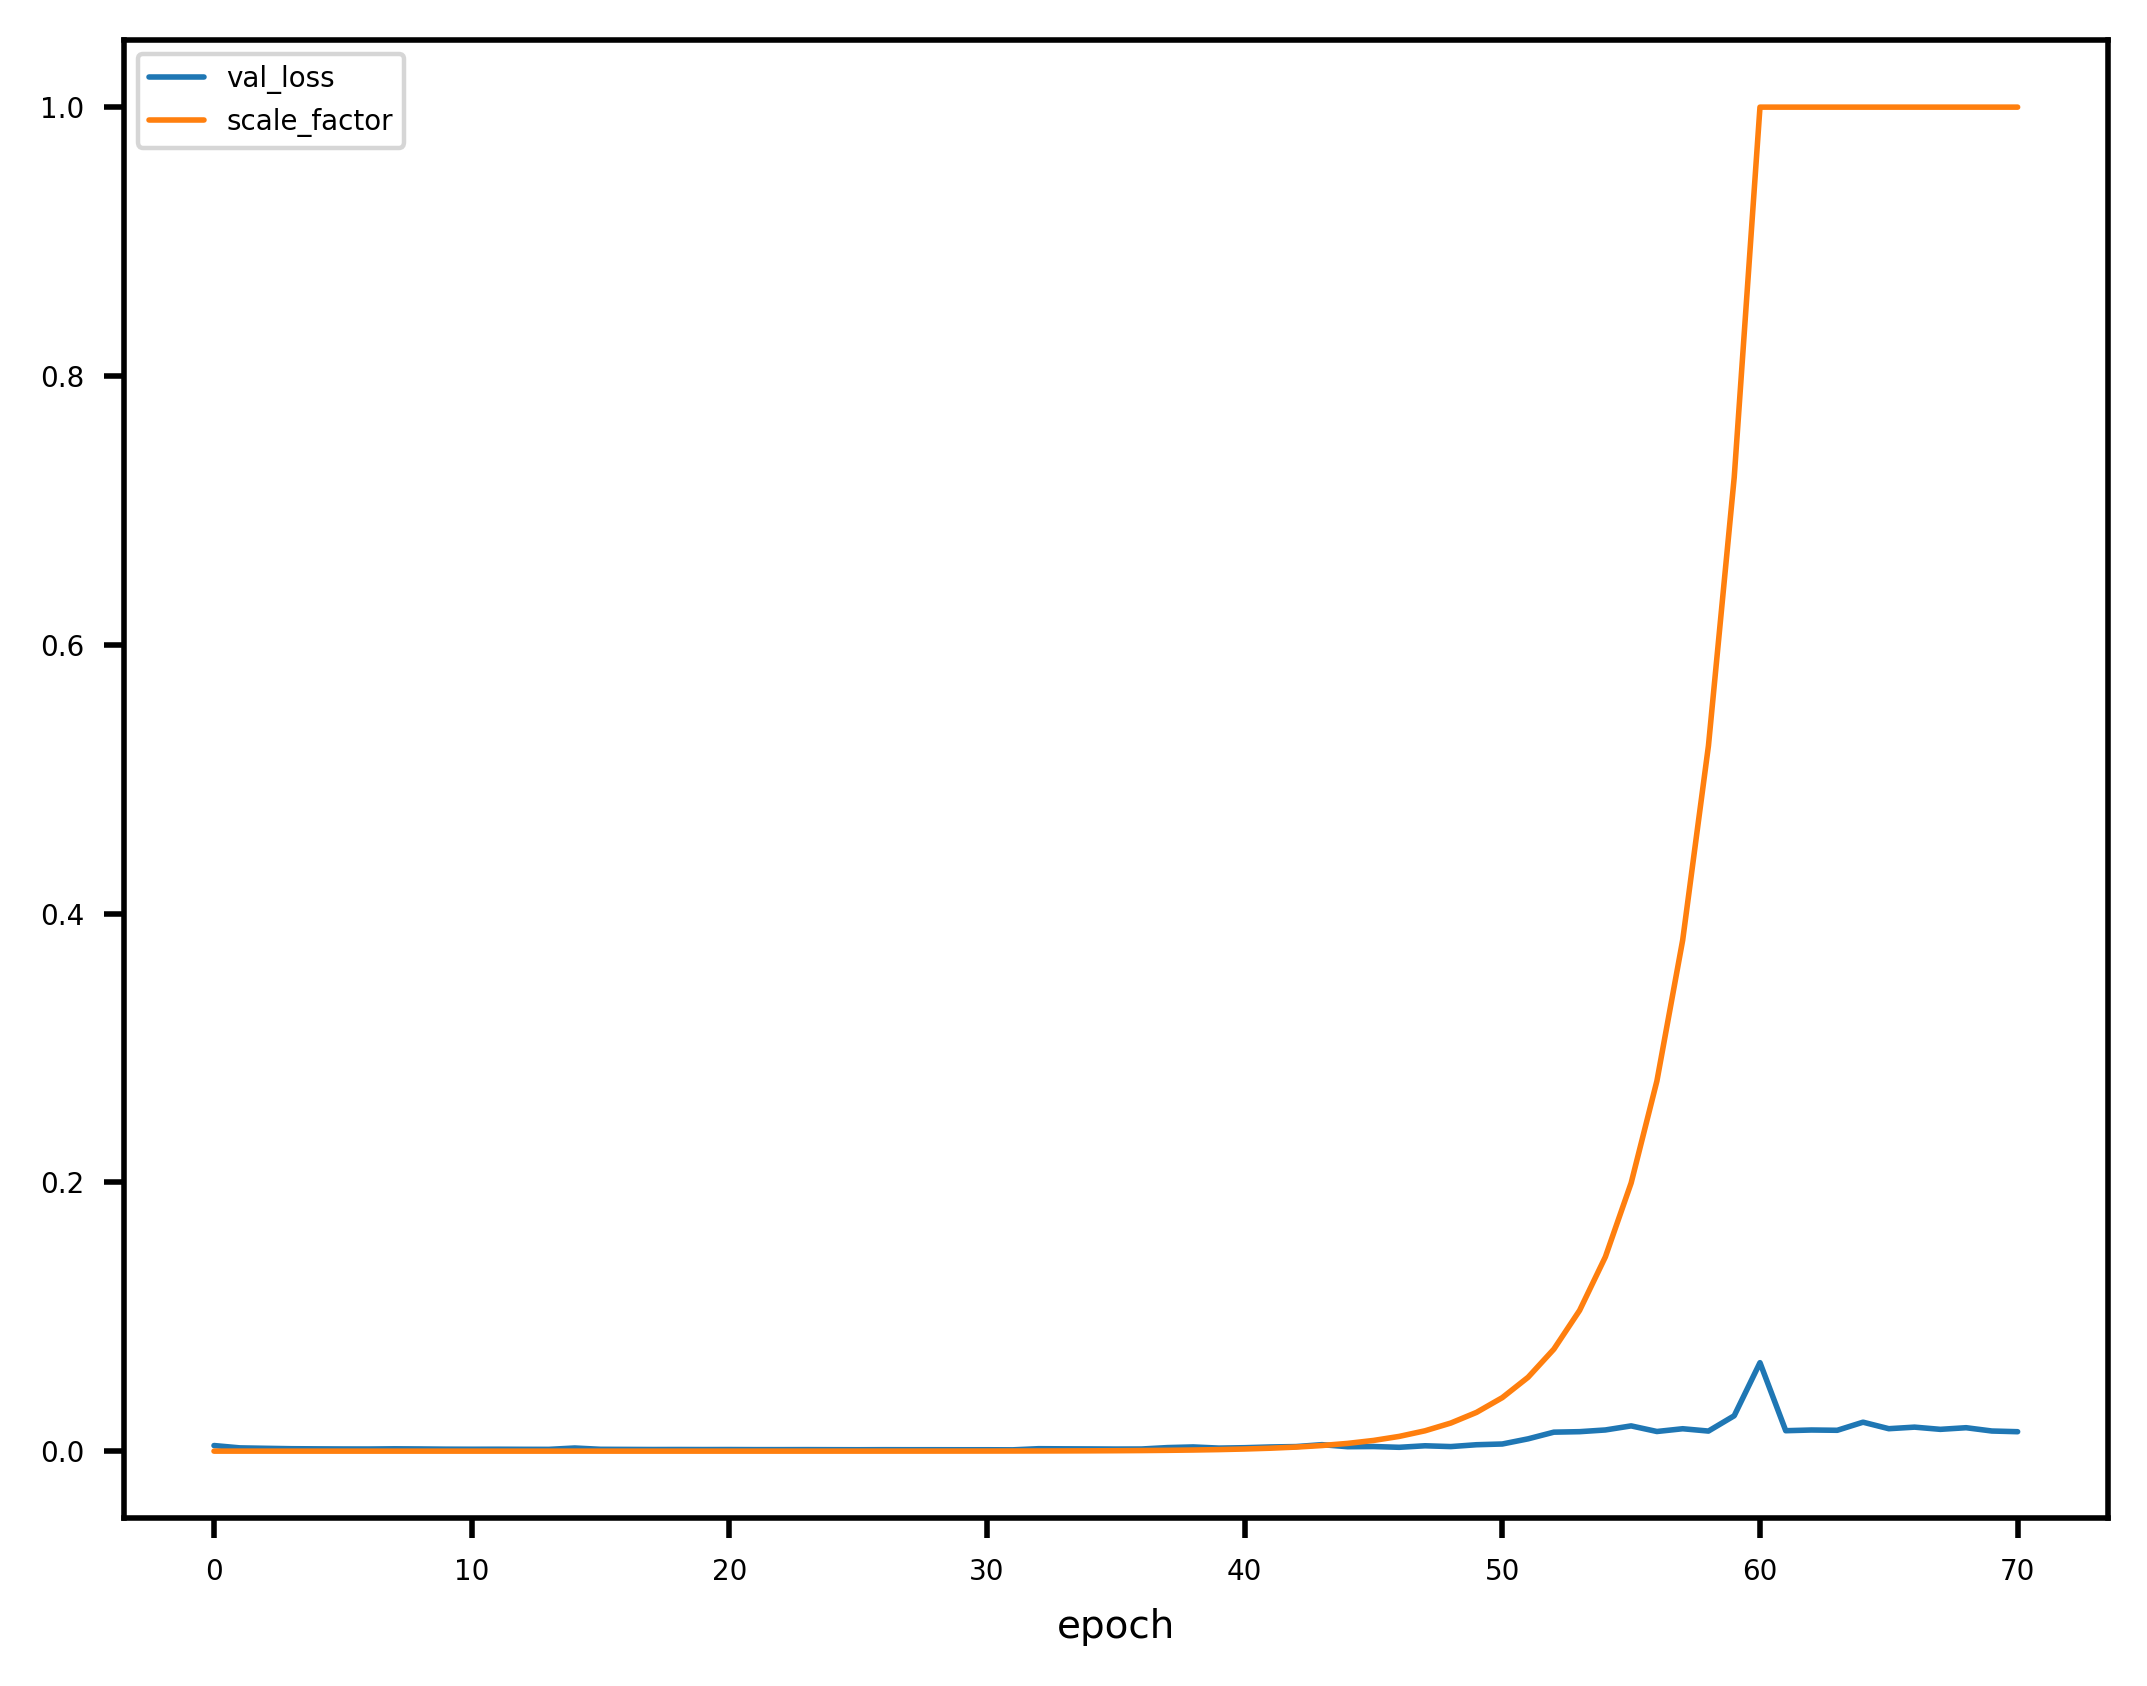

In [477]:
tmp[['val_loss', 'scale_factor']].dropna().plot()

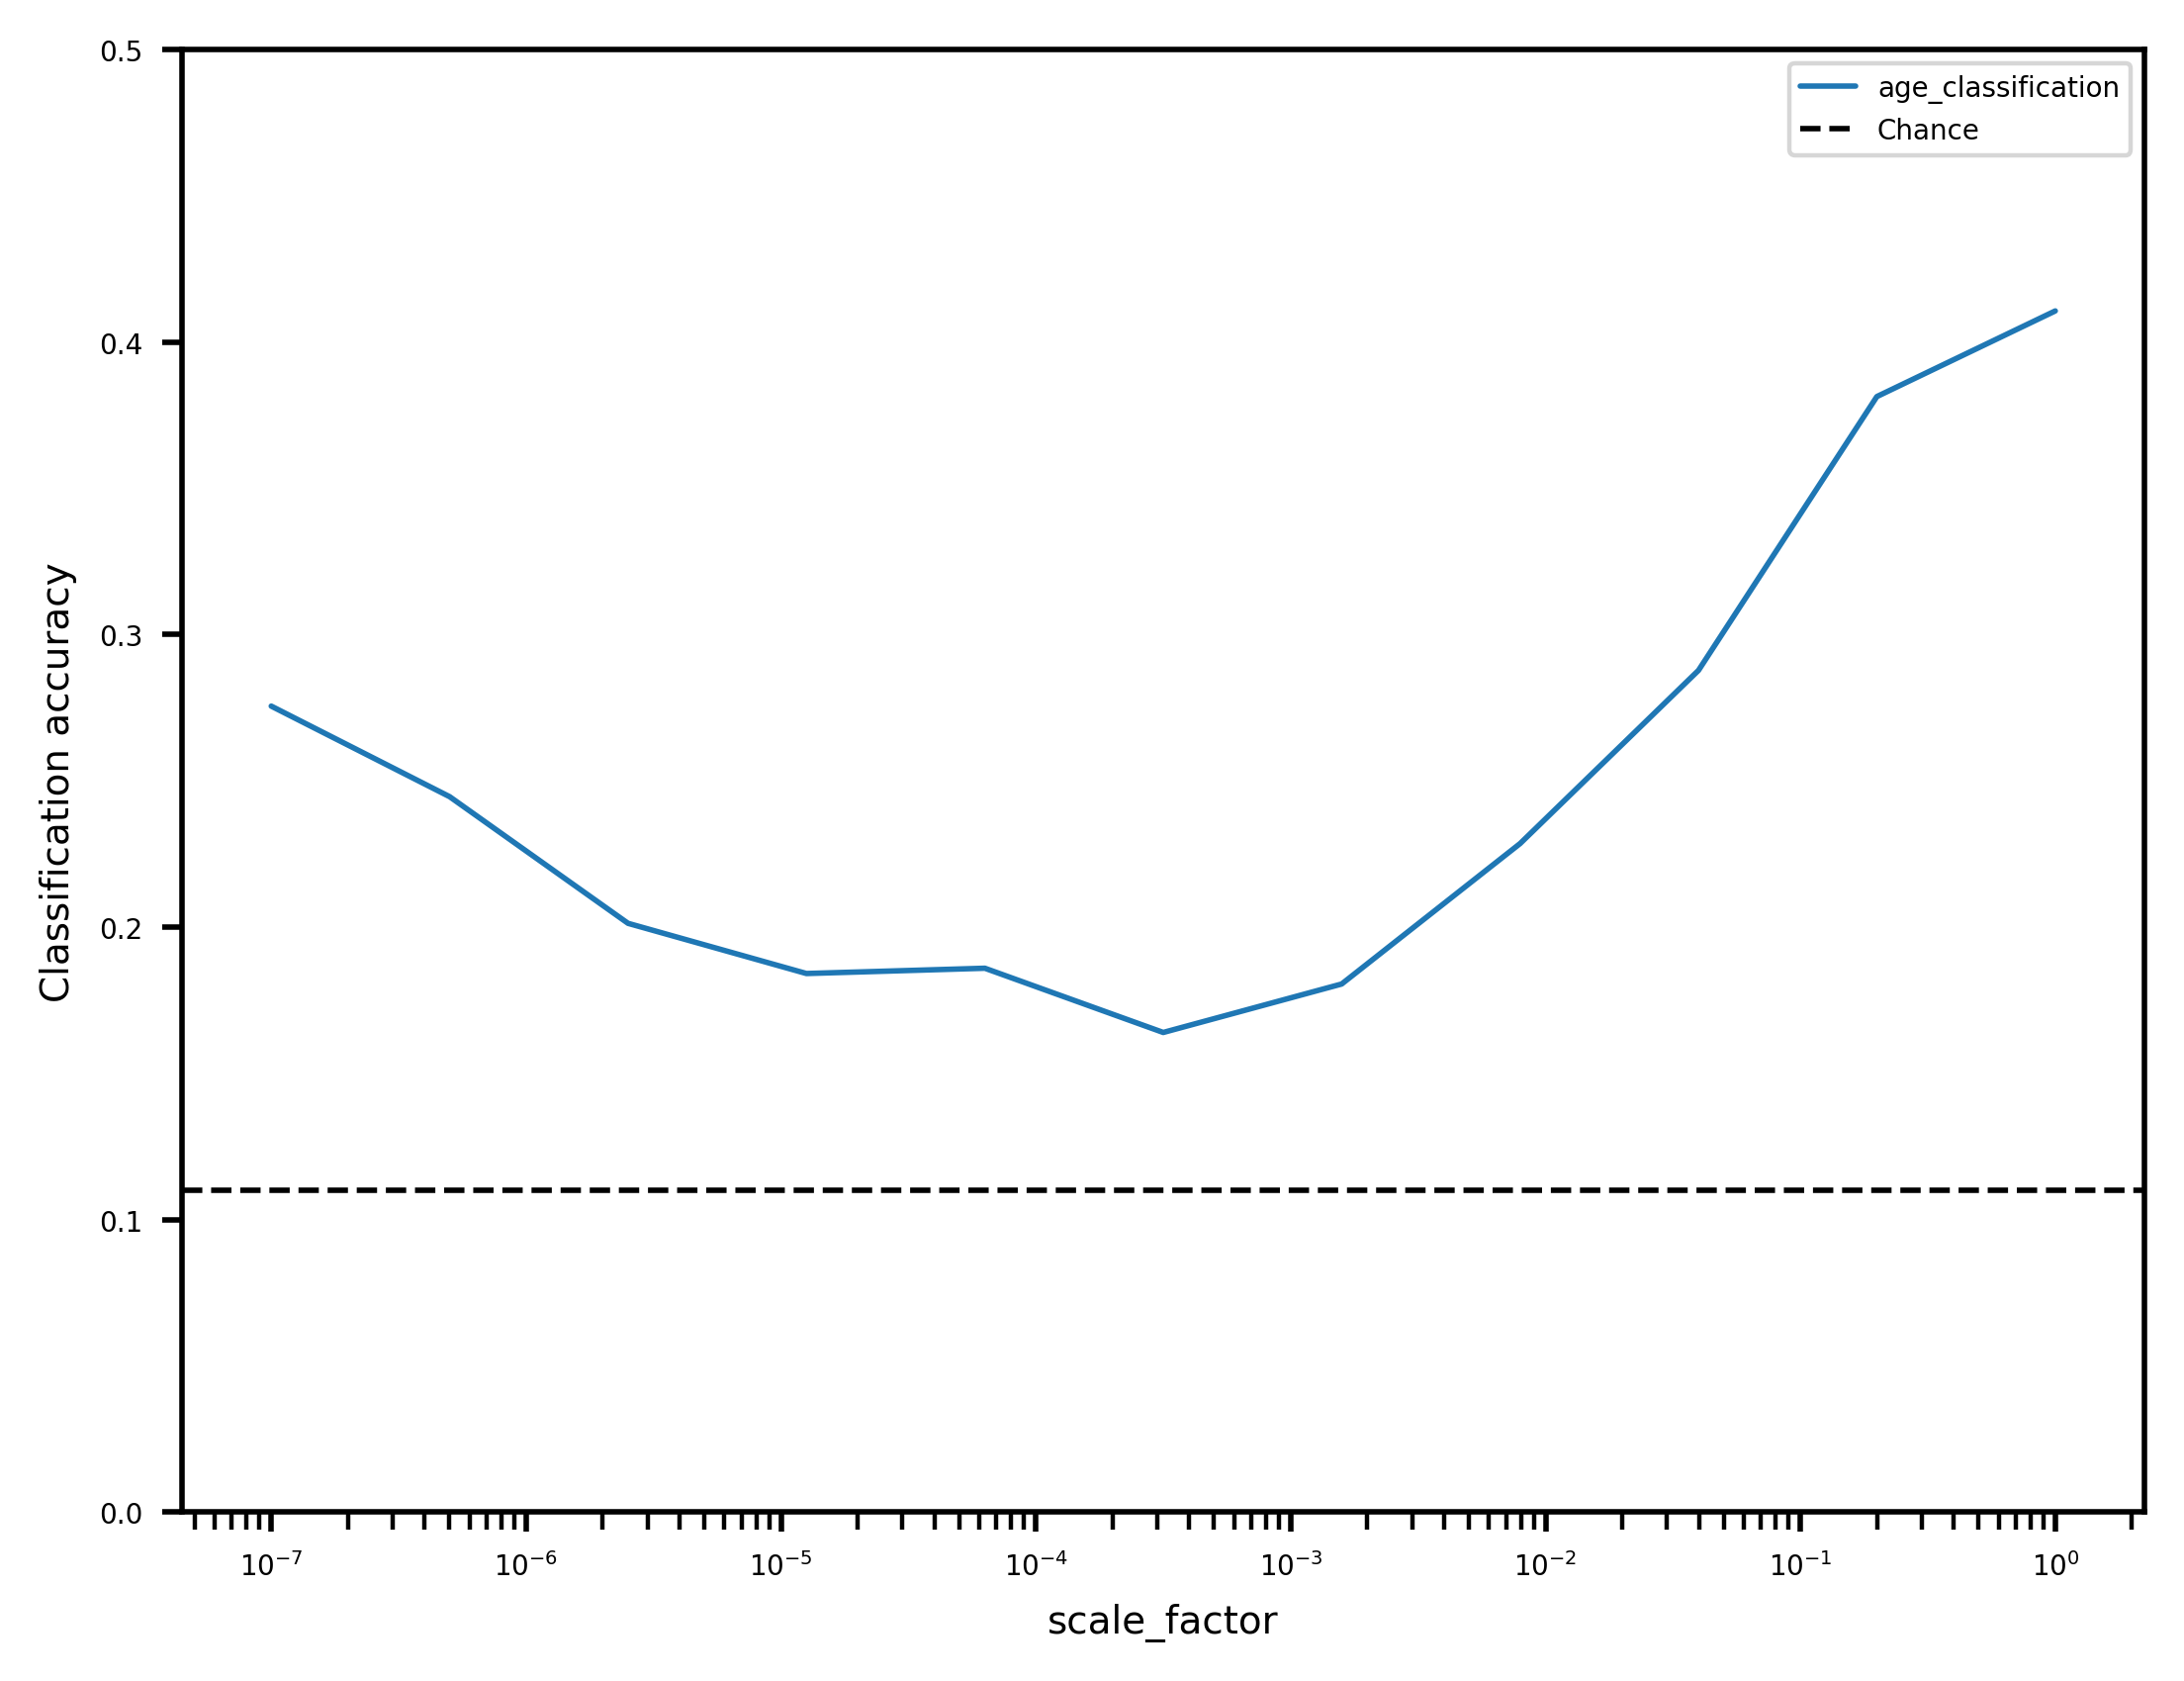

In [488]:
ax = tmp.query('scale_factor > 0')[["scale_factor", "age_classification"]].dropna().plot(
    kind="line", x="scale_factor", y="age_classification"
)
plt.axhline(0.11, color='k', ls='--', label="Chance")
ax.set_xscale("log")
ax.set_ylim(0, 0.5)
ax.set_ylabel("Classification accuracy")
plt.legend()

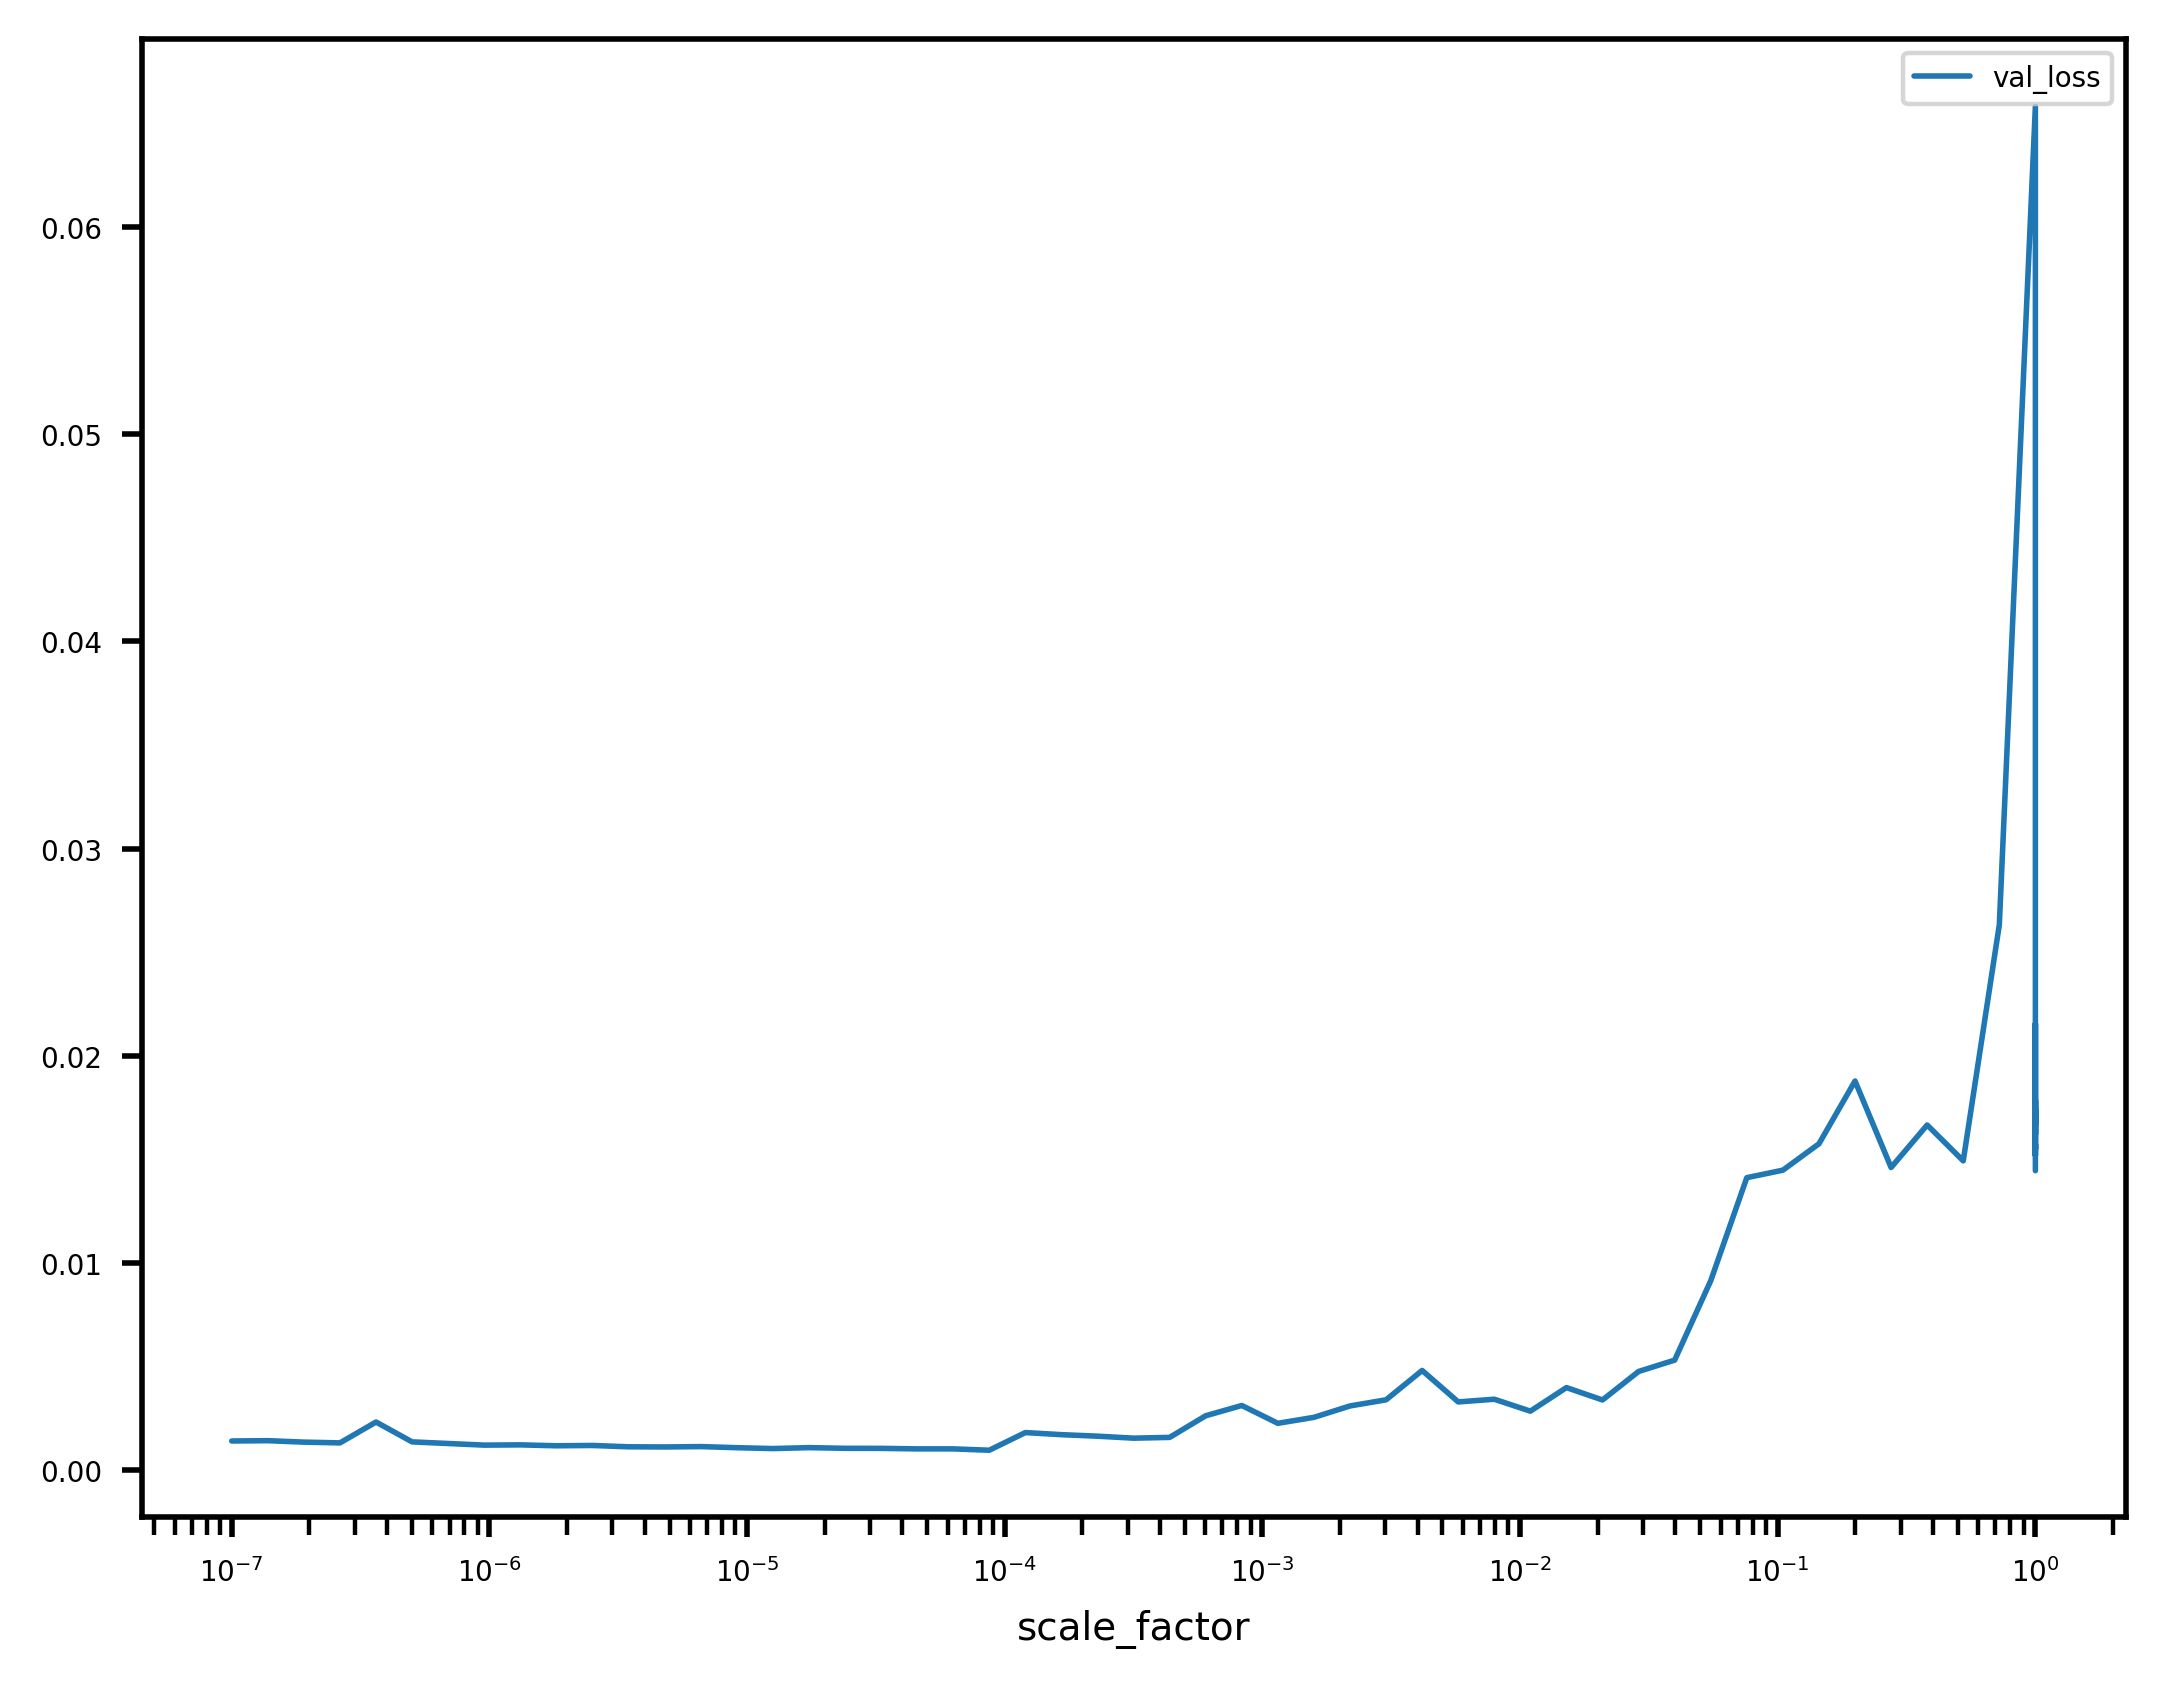

In [479]:
ax = tmp.query('scale_factor > 0')[["scale_factor", "val_loss"]].dropna().plot(
    kind="line", x="scale_factor", y="val_loss"
)
ax.set_xscale("log")

In [481]:
for k, v in dfs.items():
    tmp = v.groupby("epoch").mean()
    p = params[k]
    print(
        p["model"]["lightning"]["adversarial_arch"],
        p["model"]["lightning"]["adversarial_type"],
        tmp["age_classification"].min(),
    )

nonlinear continuous 0.1599111111111111
nonlinear class 0.1528296296296296
linear continuous 0.164
linear class 0.1724148148148148


In [489]:
# this version does not log-transform age
folder = Path('/n/groups/datta/win/longtogeny/size_norm/models/adversarial_performance_scan_01/')

In [490]:
files = list(folder.glob('**/metrics.csv'))

In [491]:
dfs = {}
params = {}
for f in files:
    dfs[f] = pd.read_csv(f)
    params[f] = toml.load(f.parents[2] / "config.toml")

In [497]:
for k, v in dfs.items():
    tmp = v.groupby("epoch").mean()
    p = params[k]
    print(
        p["model"]["lightning"]["adversarial_arch"],
        p["model"]["lightning"]["adversarial_type"],
        tmp["age_classification"].min(),
    )

nonlinear continuous 0.1606814814814814
linear continuous 0.1658962962962963


In [493]:
tmp

,train_loss,scale_factor,class_loss,step,val_loss,age_classification,dynamics_correlation
epoch,,,,,,,
0,0.027798,0.000000e+00,0.953878,270.200000,0.004542,NaN,NaN
1,0.002931,0.000000e+00,0.955568,721.400000,0.002316,NaN,NaN
2,0.003059,0.000000e+00,0.961794,1172.600000,0.002100,NaN,NaN
3,0.001991,0.000000e+00,0.958351,1623.800000,0.001817,NaN,NaN
4,0.001748,0.000000e+00,0.969551,2095.363636,0.001683,NaN,NaN
5,0.001599,0.000000e+00,0.970993,2589.363636,0.001699,0.296800,NaN
6,0.001689,0.000000e+00,0.973627,3022.400000,0.001651,NaN,NaN
7,0.001630,0.000000e+00,0.962155,3473.600000,0.001527,NaN,NaN
8,0.001586,0.000000e+00,0.943365,3945.181818,0.001487,NaN,NaN


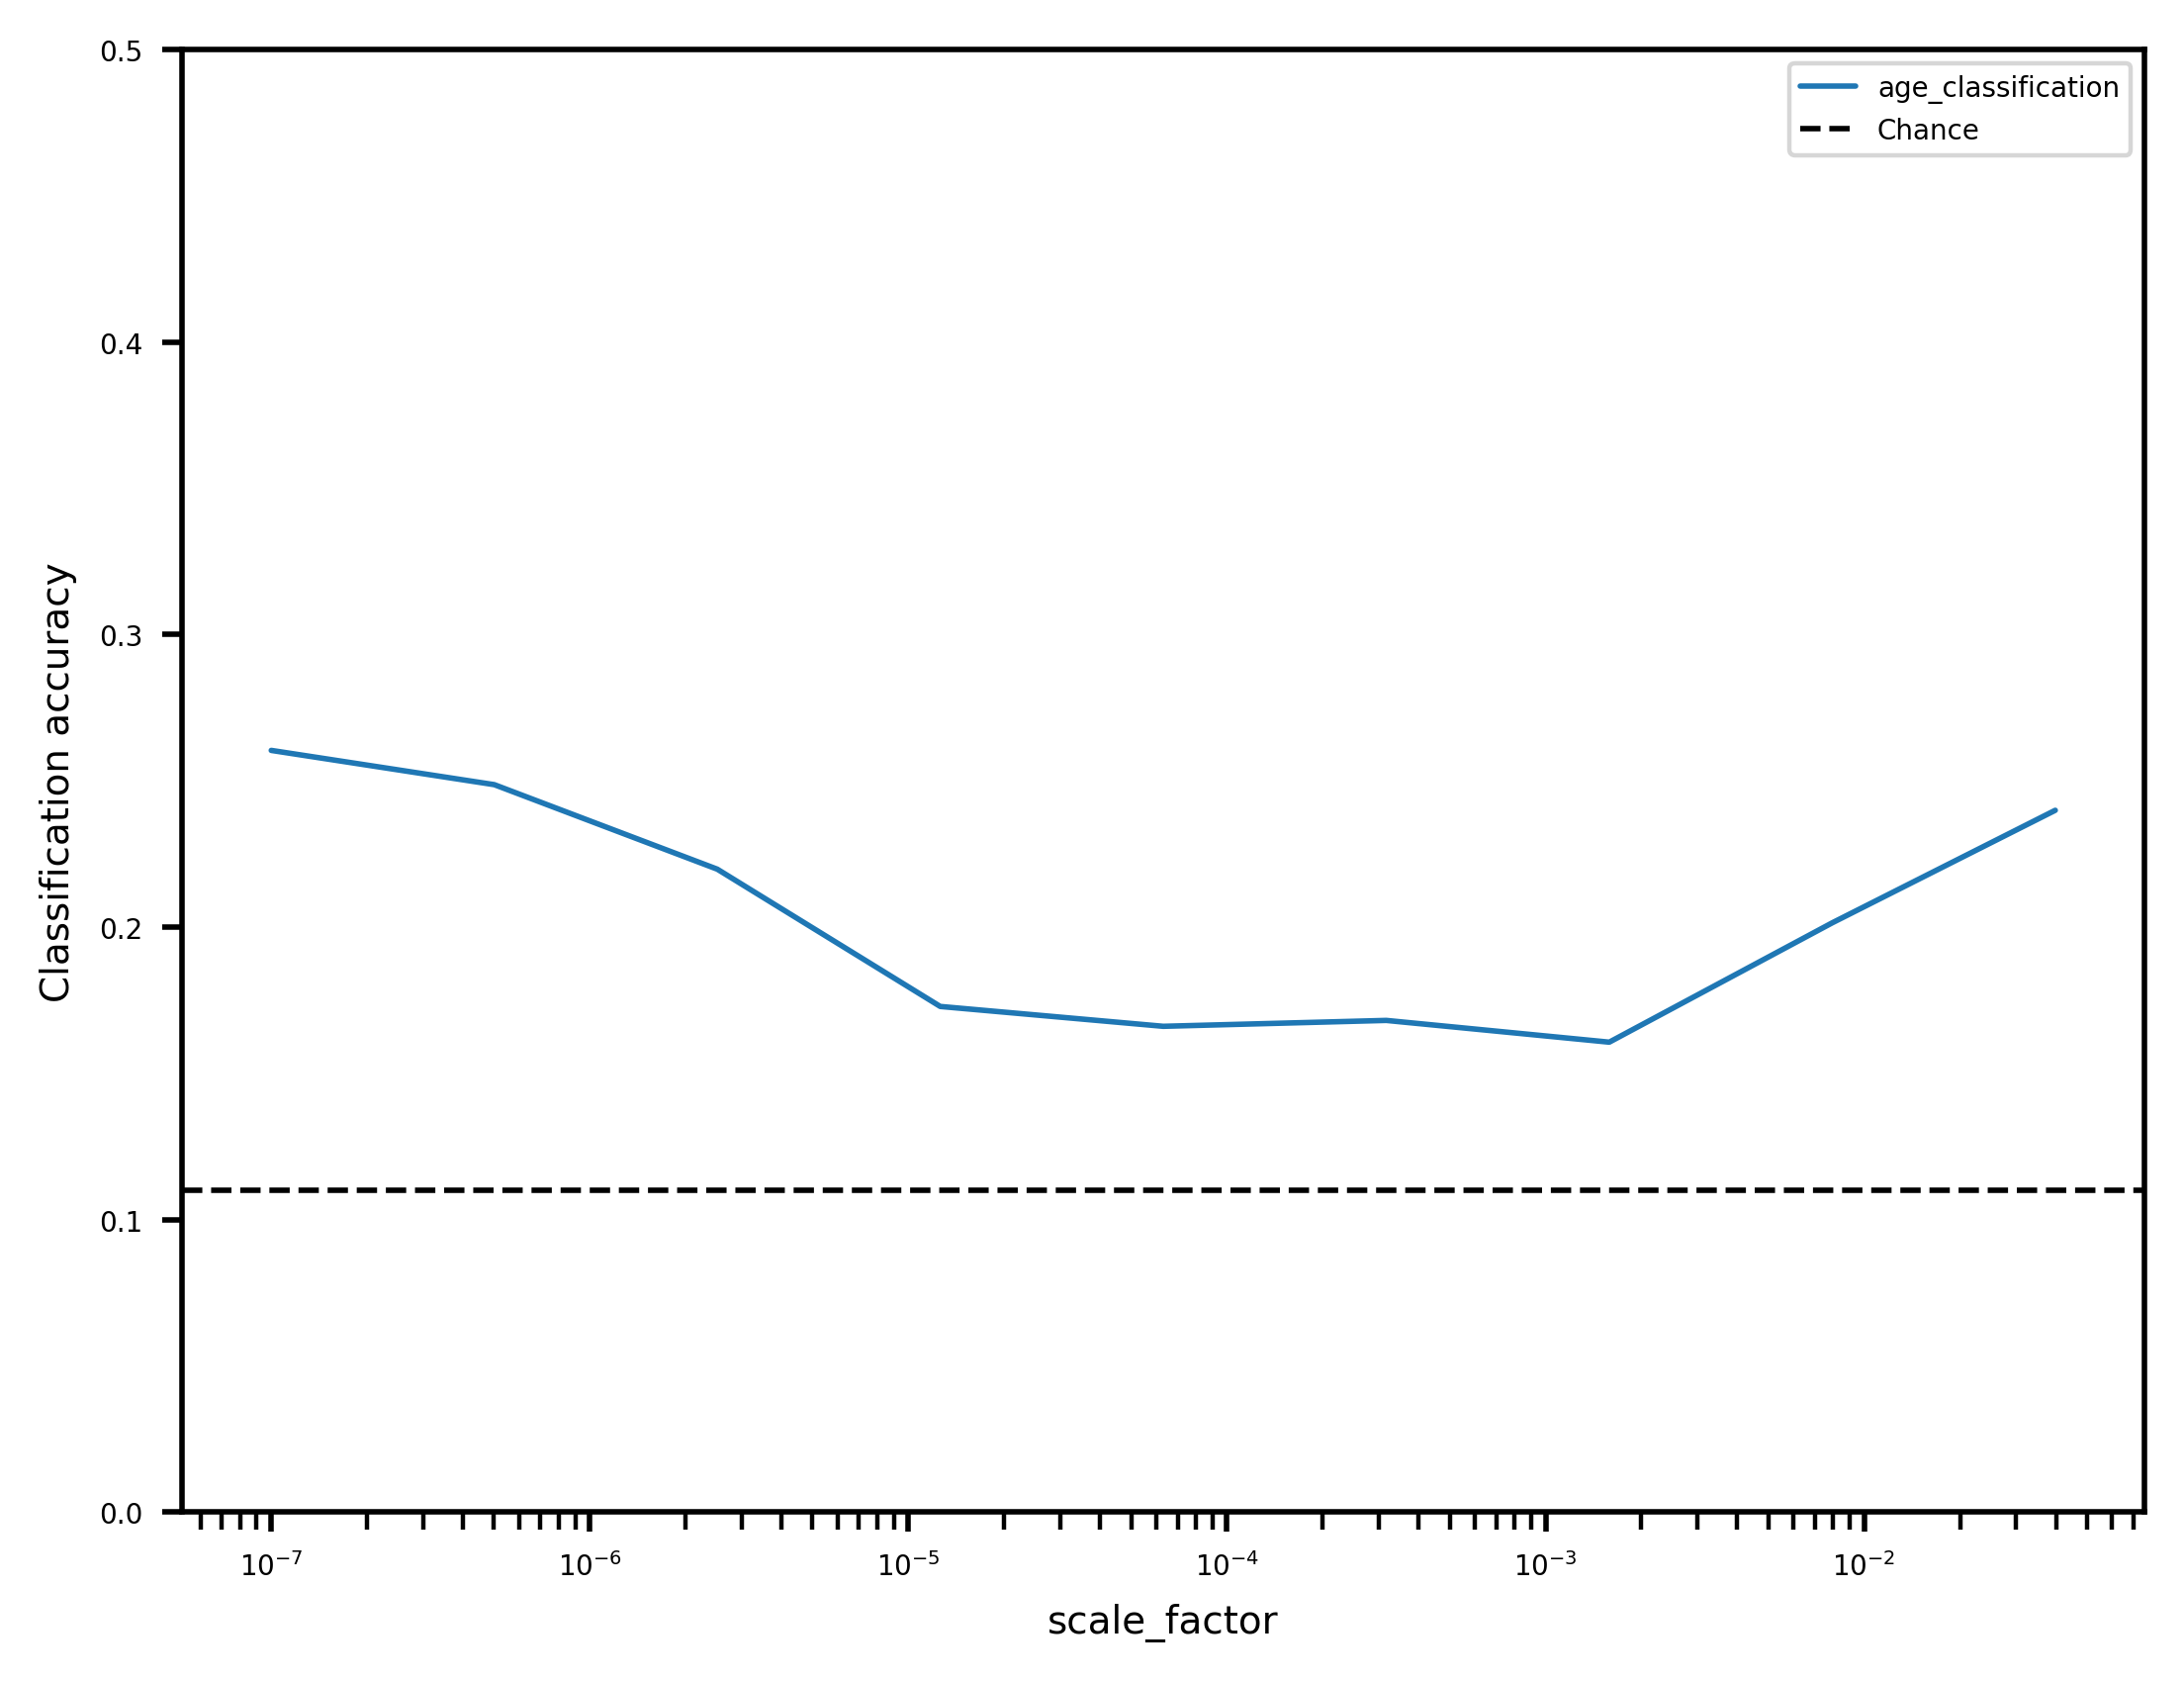

In [496]:
ax = tmp.query('scale_factor > 0')[["scale_factor", "age_classification"]].dropna().plot(
    kind="line", x="scale_factor", y="age_classification"
)
plt.axhline(0.11, color='k', ls='--', label="Chance")
ax.set_xscale("log")
ax.set_ylim(0, 0.5)
ax.set_ylabel("Classification accuracy")
plt.legend()